In [ ]:
# ===============================================================
# 0.  Drive, imports, global constants
# ===============================================================
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### HITNet with U-Net Feature Extractor

Mounted at /content/drive
Epoch 1/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 210s 2s/step - loss: 21.4307 - val_loss: 21.5759
Epoch 2/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 82s 912ms/step - loss: 20.1128 - val_loss: 15.5922
Epoch 3/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 84s 940ms/step - loss: 15.1538 - val_loss: 14.2889
Epoch 4/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 79s 904ms/step - loss: 14.1308 - val_loss: 12.5942
Epoch 5/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 85s 938ms/step - loss: 13.0825 - val_loss: 11.9892
Epoch 6/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 72s 901ms/step - loss: 12.6120 - val_loss: 11.3136
Epoch 7/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 85s 937ms/step - loss: 12.1436 - val_loss: 10.8870
Epoch 8/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 82s 938ms/step - loss: 11.5236 - val_loss: 10.3478
Epoch 9/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 82s 939ms/step - loss: 11.0093 - val_loss: 9.6804
Epoch 10/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 79s 906ms/step - loss: 10.9736 - val_loss: 9.5484
Epoch 11/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 74s 931ms/step - loss: 10.1080 - val_loss: 8.800

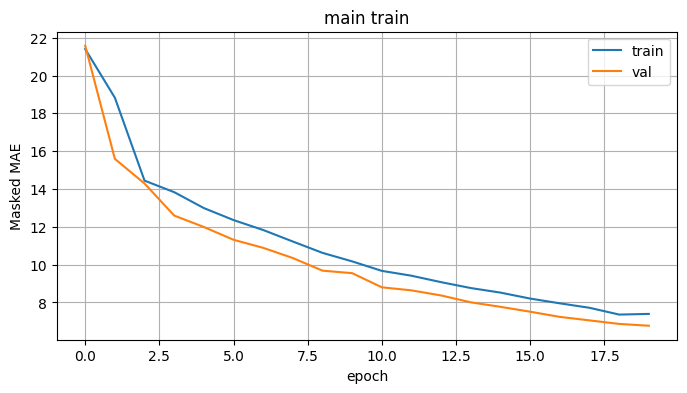

In [ ]:
# ===============================================================
# 0.  Drive, imports, global constants
# ===============================================================
from google.colab import drive
drive.mount('/content/drive')

import tensorflow as tf, numpy as np, matplotlib.pyplot as plt
from tensorflow.keras import layers, Model
from sklearn.model_selection import train_test_split
import glob, os, time

# ---------- hyper-params ----------
TARGET_SIZE  = (384, 1248)      # (H, W)
BATCH_SIZE   = 2
VAL_SPLIT    = 0.20
MAX_DISP     = 192              # covers KITTI / Scene-Flow
N_SHOW       = 5                # how many *batches* to visualise
SAVE_DIR     = "/content/drive/MyDrive/hitnet_vis"

# pick the stereo feature extractor here:  "lite" | "unet" | "mobilenet"
BACKBONE_TYPE = "unet"

LEFT_DIR  = "/content/drive/MyDrive/EE 417/data-scene-flow/training/image_2"
RIGHT_DIR = "/content/drive/MyDrive/EE 417/data-scene-flow/training/image_3"
GT_DIR    = "/content/drive/MyDrive/EE 417/data-scene-flow/training/disp_occ_0"

# ===============================================================
# 1.  Data helpers
# ===============================================================
def load_rgb(fp):
    img = tf.image.decode_png(tf.io.read_file(fp), channels=3)
    return tf.image.convert_image_dtype(img, tf.float32)

def load_disp(fp):
    raw = tf.image.decode_png(tf.io.read_file(fp), channels=1, dtype=tf.uint16)
    return tf.cast(raw, tf.float32) / 256.0          # KITTI scale factor

def list_png(folder):
    """{basename: full_path} for every PNG in *folder*."""
    return {os.path.basename(p): p for p in glob.glob(f"{folder}/*.png")}

# ----------------------------------------------------------------
def make_datasets():
    L_all, R_all, G_all = list_png(LEFT_DIR), list_png(RIGHT_DIR), list_png(GT_DIR)
    keys = sorted([k for k in L_all if k in R_all and k in G_all])
    tr_keys, va_keys = train_test_split(keys, test_size=VAL_SPLIT, random_state=42)

    def build(keys):
        l_paths = tf.constant([L_all[k] for k in keys])
        r_paths = tf.constant([R_all[k] for k in keys])
        g_paths = tf.constant([G_all[k] for k in keys])

        def _parse(l, r, g):
            Limg = tf.image.resize(load_rgb(l),  TARGET_SIZE)
            Rimg = tf.image.resize(load_rgb(r),  TARGET_SIZE)
            Dimg = tf.image.resize(load_disp(g), TARGET_SIZE, method='nearest')
            return (Limg, Rimg), Dimg

        return (tf.data.Dataset.from_tensor_slices((l_paths, r_paths, g_paths))
                .map(_parse, tf.data.AUTOTUNE)
                .batch(BATCH_SIZE)
                .prefetch(tf.data.AUTOTUNE))

    return build(tr_keys), build(va_keys)

train_ds, val_ds = make_datasets()

# ===============================================================
# 2.  Backbones   (lite  |  unet  |  mobilenet)
# ===============================================================
def conv_block(x, ch, k=3):
    """Two Conv → BN → ReLU layers (U-Net helper)."""
    for _ in range(2):
        x = layers.Conv2D(ch, k, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
    return x

# ----- U-Net backbone ---------------------------------------------------------
def unet_backbone(base=32, depth=4):
    inp, skips = layers.Input(shape=(None, None, 3)), []
    x = inp
    # encoder
    for d in range(depth):
        x = conv_block(x, base * 2**d)
        skips.append(x)
        x = layers.MaxPool2D(2)(x)
    # bottleneck
    x = conv_block(x, base * 2**depth)
    # decoder
    for d in reversed(range(depth)):
        x = layers.Conv2DTranspose(base * 2**d, 2, 2, padding='same')(x)
        x = layers.Concatenate()([x, skips[d]])
        x = conv_block(x, base * 2**d)
    out = layers.Conv2D(base, 1, padding='same', activation='relu')(x)
    return Model(inp, out, name="UNetBackbone")

# ----- original tiny backbone -------------------------------------------------
def lite_backbone(base=16):
    inp = layers.Input(shape=(None, None, 3))
    x1  = layers.Conv2D(base,   3, 2, padding='same', activation='relu')(inp)
    x2  = layers.Conv2D(base*2, 3, 2, padding='same', activation='relu')(x1)
    x2  = layers.Conv2D(base*2, 3, 1, padding='same', activation='relu')(x2)
    up  = layers.Conv2DTranspose(base, 3, 2, padding='same', activation='relu')(x2)
    up  = layers.Lambda(lambda t: t[0][:, :tf.shape(t[1])[1],
                                          :tf.shape(t[1])[2], :])([up, x1])
    up  = layers.Concatenate()([up, x1])
    up  = layers.Conv2DTranspose(base, 3, 2, padding='same', activation='relu')(up)
    out = layers.Conv2D(base, 3, padding='same', activation='relu')(up)
    return Model(inp, out, name="LiteBackbone")

# ----- MobileNet-V2 backbone --------------------------------------------------
def mobilenet_backbone(width=0.75):
    from tensorflow.keras.applications import MobileNetV2
    base_model = MobileNetV2(include_top=False,
                             input_shape=(None, None, 3),
                             alpha=width,
                             weights=None)
    feat = base_model.get_layer('block_13_expand_relu').output   # stride 8
    out  = layers.Conv2D(32, 1, padding='same', activation='relu')(feat)
    return Model(base_model.input, out, name="MobileNetBackbone")

# ===============================================================
# 2b.  Init & Propagation modules (unchanged)
# ===============================================================
class InitLayer(layers.Layer):
    def __init__(self, D=MAX_DISP):
        super().__init__()
        self.D = D
    def call(self, feats):
        FL, FR = feats
        cost_vol = []
        for d in range(self.D):
            shift = FR if d == 0 else tf.pad(FR[:, :, :-d, :],
                                             [[0,0],[0,0],[d,0],[0,0]])
            diff  = tf.reduce_mean(tf.abs(FL - shift), axis=-1, keepdims=True)
            cost_vol.append(diff)
        volume = tf.concat(cost_vol, axis=-1)
        disp0  = tf.cast(tf.argmin(volume, axis=-1), tf.float32)[..., None]
        return disp0

class PropLayer(layers.Layer):
    def __init__(self):
        super().__init__()
        self.c1 = layers.Conv2D(32, 3, padding='same', activation='relu')
        self.c2 = layers.Conv2D(1,  3, padding='same')
    def warp(self, FR, D):
        B, H, W, _ = tf.unstack(tf.shape(FR))
        D_res = tf.image.resize(D, [H, W], 'bilinear')
        grid_x = tf.tile(tf.reshape(tf.range(W, dtype=tf.float32),
                                    (1,1,W,1)), [B, H, 1, 1])
        xs = tf.round(grid_x - D_res)
        xs = tf.clip_by_value(xs, 0.0, tf.cast(W-1, tf.float32))
        idx = tf.stack([
            tf.tile(tf.reshape(tf.range(B), [-1,1,1]), [1,H,W]),
            tf.tile(tf.reshape(tf.range(H), [1,-1,1]), [B,1,W]),
            tf.cast(xs[...,0], tf.int32)
        ], axis=-1)
        return tf.gather_nd(FR, idx)
    def call(self, inputs):
        FL, FR, D0 = inputs
        WR  = self.warp(FR, D0)
        D0u = tf.image.resize(D0, tf.shape(FL)[1:3], 'bilinear')
        x   = self.c1(tf.concat([FL, WR, D0u], axis=-1))
        return D0u + self.c2(x)

# ===============================================================
# 2c.  HITNet wrapper with pluggable backbone
# ===============================================================
class HITNet(Model):
    def __init__(self, backbone_type="lite"):
        super().__init__()
        if   backbone_type == "unet":
            self.bb = unet_backbone(base=32)
        elif backbone_type == "mobilenet":
            self.bb = mobilenet_backbone(width=0.75)
        else:
            self.bb = lite_backbone()
        self.init = InitLayer()
        self.prop = PropLayer()
    def call(self, inputs):
        L, R = inputs
        FL, FR = self.bb(L), self.bb(R)
        D0 = self.init([FL, FR])
        return self.prop([FL, FR, D0])

# ===============================================================
# 3.  Masked-MAE loss (ignore GT == 0)
# ===============================================================
def masked_mae(y_true, y_pred):
    mask = tf.cast(y_true > 0.0, tf.float32)
    err  = tf.abs(y_true - y_pred) * mask
    return tf.reduce_sum(err) / tf.reduce_sum(mask)

# ===============================================================
# 4.  KITTI metrics + evaluation
# ===============================================================
def kitti_d1_all(pred, gt):
    mask  = tf.cast(gt > 0.0, tf.float32)
    abs_e = tf.abs(pred - gt)
    rel_e = abs_e / tf.maximum(gt, 1e-6)
    bad   = tf.logical_and(abs_e > 3.0, rel_e > 0.05)
    bad   = tf.cast(bad, tf.float32) * mask
    return tf.reduce_sum(bad), tf.reduce_sum(mask)

def mae_rmse(pred, gt):
    mask  = tf.cast(gt > 0.0, tf.float32)
    abs_e = tf.abs(pred - gt) * mask
    sqe   = tf.square(pred - gt) * mask
    return tf.reduce_sum(abs_e), tf.reduce_sum(sqe), tf.reduce_sum(mask)

def evaluate(model, dataset):
    mae_sum = sqe_sum = bad_sum = pix_sum = img_cnt = 0.0
    start   = time.perf_counter()
    for (L, R), GT in dataset:
        pred = model([L, R], training=False)[..., 0]
        gt   = GT[..., 0]
        ae, se, valid = mae_rmse(pred, gt)
        bad, _        = kitti_d1_all(pred, gt)
        mae_sum += ae.numpy(); sqe_sum += se.numpy()
        bad_sum += bad.numpy(); pix_sum += valid.numpy()
        img_cnt += int(L.shape[0])
    sec_pair = (time.perf_counter() - start) / img_cnt
    mae      = mae_sum / pix_sum
    rmse     = np.sqrt(sqe_sum / pix_sum)
    d1       = (bad_sum / pix_sum) * 100.0
    return sec_pair, d1, mae, rmse

# ===============================================================
# 5.  Train → fine-tune → evaluate
# ===============================================================
def plot_loss(hist, title):
    plt.figure(figsize=(8,4))
    plt.plot(hist.history['loss'], label='train')
    plt.plot(hist.history['val_loss'], label='val')
    plt.xlabel('epoch'); plt.ylabel('Masked MAE')
    plt.title(title); plt.grid(); plt.legend(); plt.show()

model = HITNet(backbone_type=BACKBONE_TYPE)
_ = model((tf.zeros((1, *TARGET_SIZE, 3)),) * 2)   # build weights

# ----- main training -----
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss=masked_mae)
hist = model.fit(train_ds, validation_data=val_ds, epochs=20)
plot_loss(hist, "main train")


In [ ]:
# ----- final evaluation -----
sec, d1, mae, rmse = evaluate(model, val_ds)
print(f"Disparity computation time: {sec:.2f}s")
print(f"KITTI D1-all error       = {d1:.2f}%")
print(f"MAE: {mae:.2f} px | RMSE: {rmse:.2f} px")


Disparity computation time: 1.02s
KITTI D1-all error       = 62.17%
MAE: 6.84 px | RMSE: 10.40 px


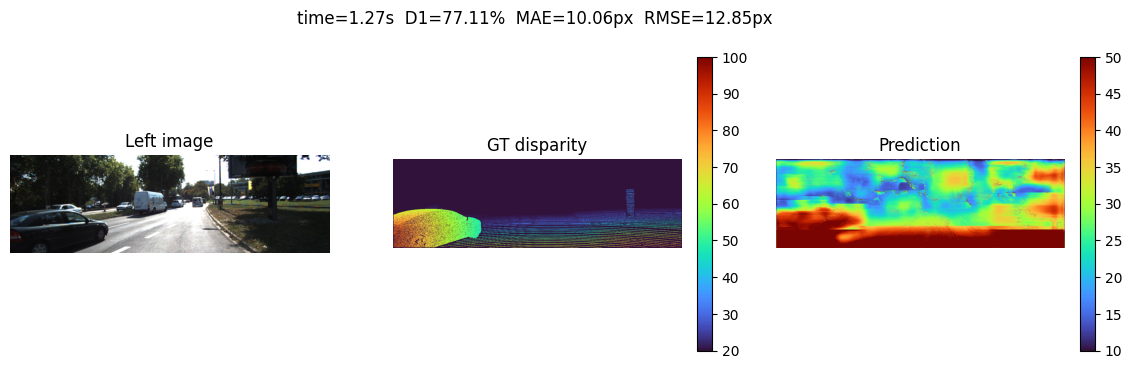

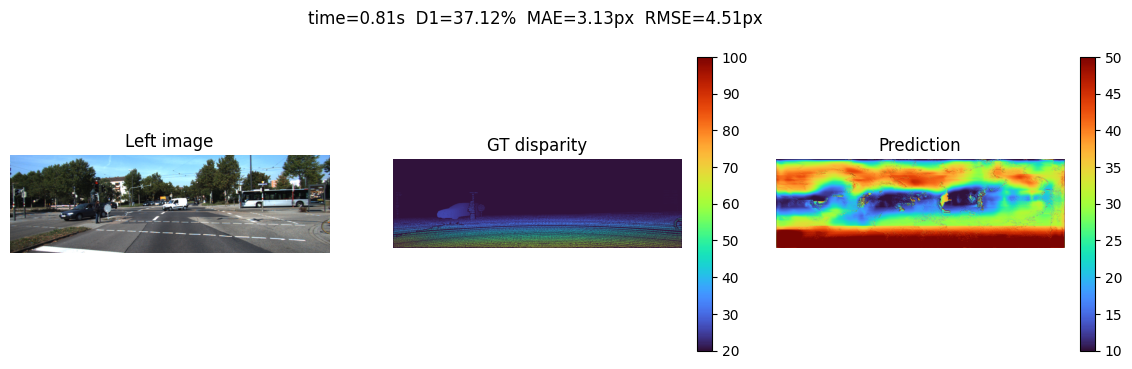

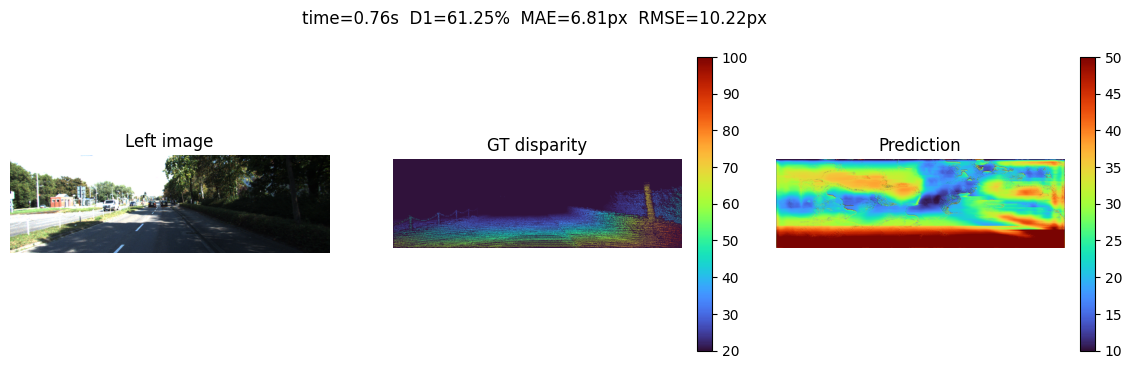

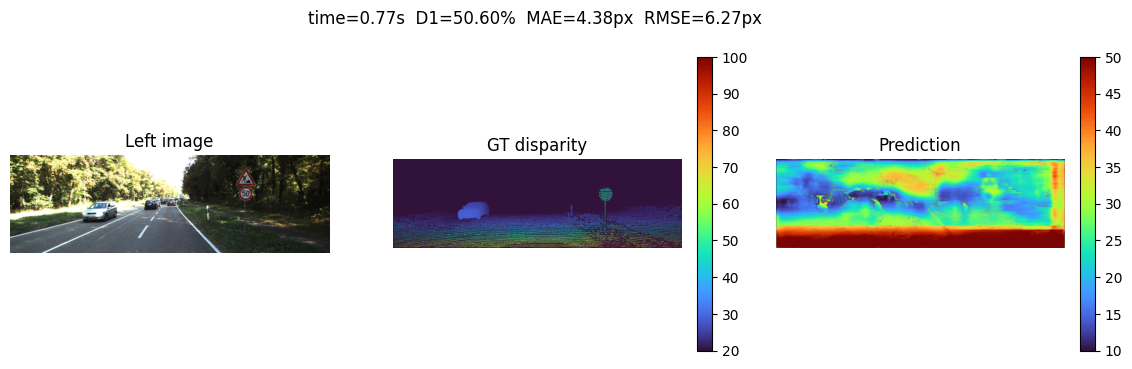

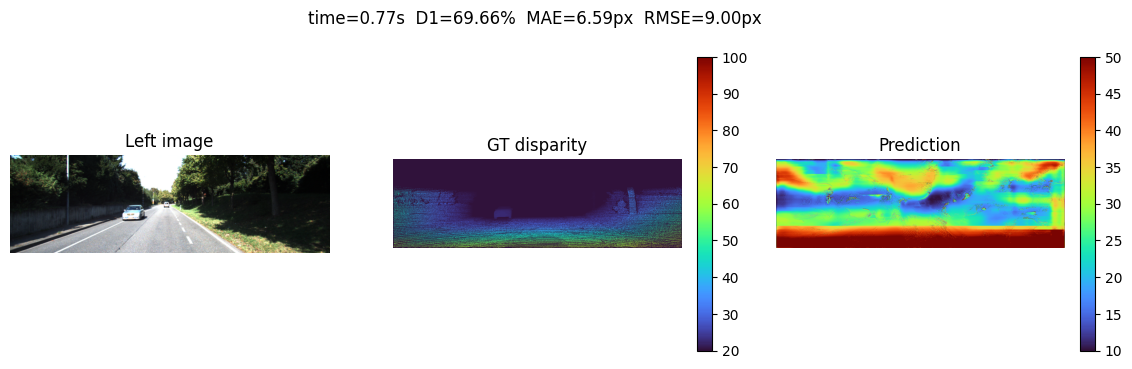

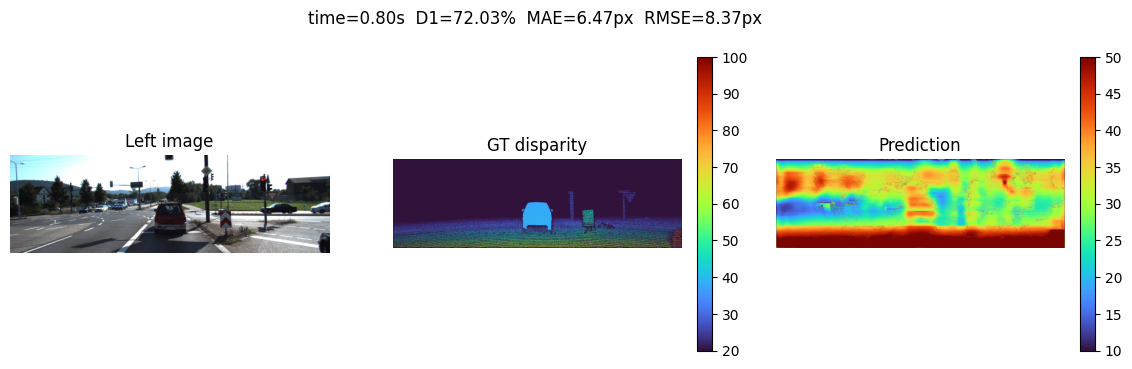

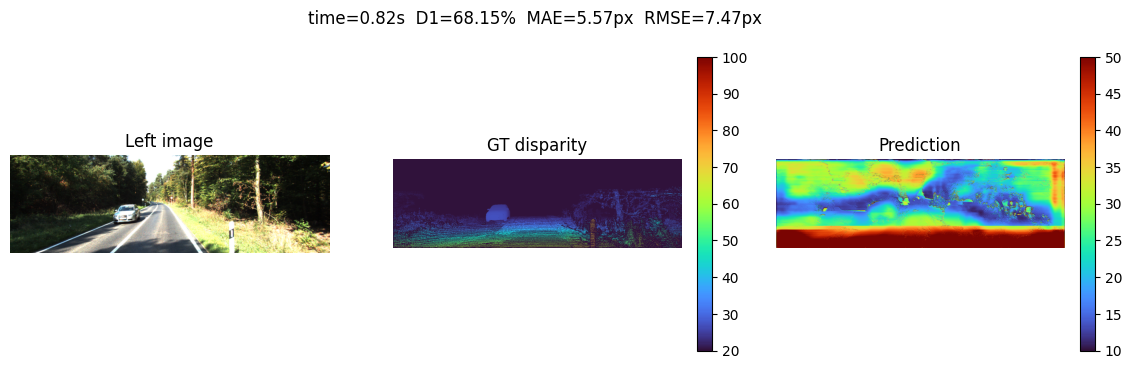

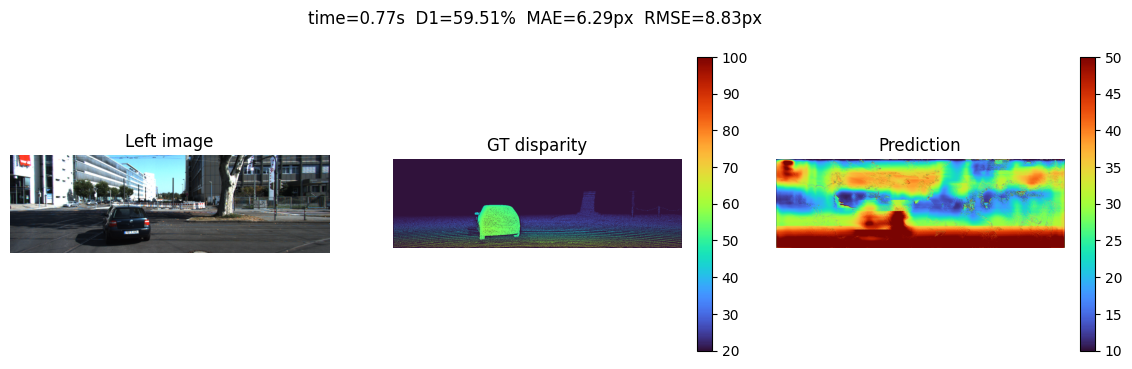

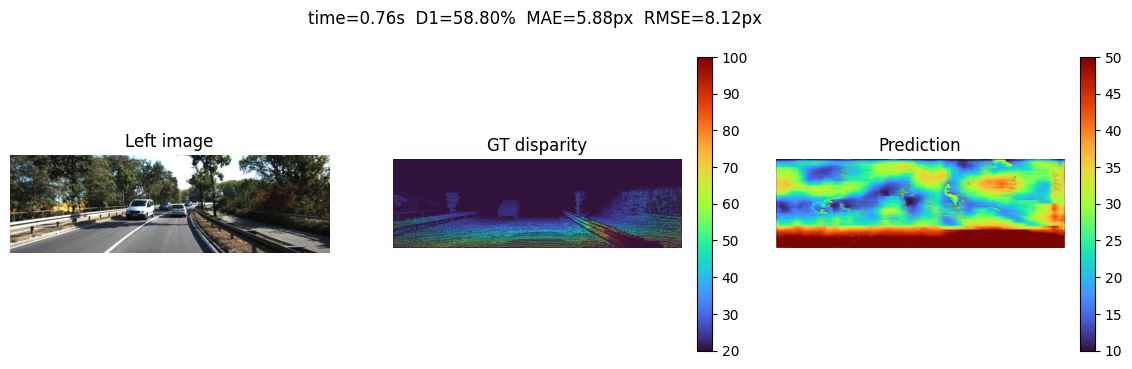

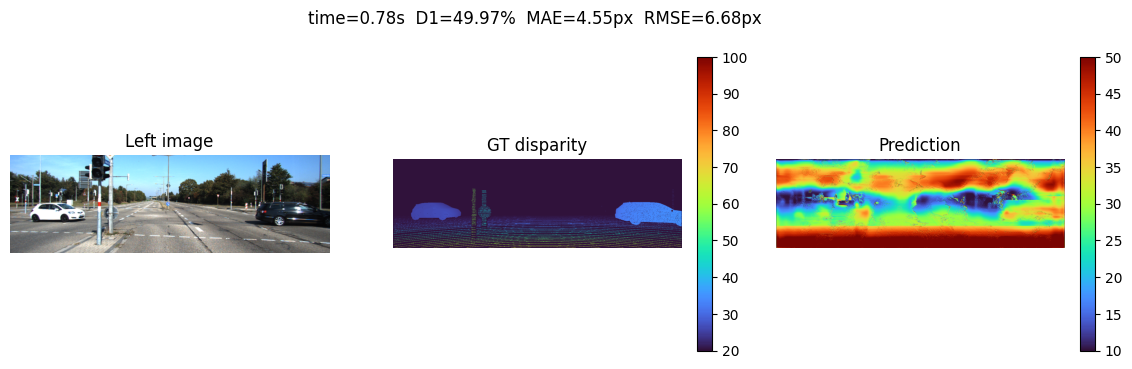

In [ ]:
#vmin, vmax = 20, 50  # consistent for both GT and Prediction

os.makedirs(SAVE_DIR, exist_ok=True)
batch_counter = 0

for (Ls, Rs), Ds in val_ds.take(N_SHOW):
    preds = model([Ls, Rs], training=False)[..., 0].numpy()
    for img_idx in range(Ls.shape[0]):
        single_ds = tf.data.Dataset.from_tensor_slices(
            ((Ls[img_idx][None], Rs[img_idx][None]), Ds[img_idx][None])
        ).batch(1)
        t_img, d1_img, mae_img, rmse_img = evaluate(model, single_ds)

        fig, ax = plt.subplots(1, 3, figsize=(14, 4))

        ax[0].imshow(Ls[img_idx])
        ax[0].set_title("Left image")
        ax[0].axis("off")

        im2 = ax[1].imshow(Ds[img_idx, ..., 0], cmap='turbo', vmin=20, vmax=100)
        ax[1].set_title("GT disparity")
        ax[1].axis("off")
        fig.colorbar(im2, ax=ax[1], fraction=0.046)

        im3 = ax[2].imshow(preds[img_idx], cmap='turbo', vmin=10, vmax=50)
        ax[2].set_title("Prediction")
        ax[2].axis("off")
        fig.colorbar(im3, ax=ax[2], fraction=0.046)

        fig.suptitle(f"time={t_img:.2f}s  D1={d1_img:.2f}%  MAE={mae_img:.2f}px  RMSE={rmse_img:.2f}px")
        fig.savefig(f"{SAVE_DIR}/sample_{batch_counter}_{img_idx}.png", dpi=150, bbox_inches="tight")
        plt.show()
        plt.close(fig)

    batch_counter += 1


### HITNet with Mobilenet Feature Extractor

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 56s 279ms/step - loss: 27.4452 - val_loss: 26.0564
Epoch 2/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - loss: 24.3154 - val_loss: 17.2615
Epoch 3/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 18s 104ms/step - loss: 16.9617 - val_loss: 16.0074
Epoch 4/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - loss: 16.3568 - val_loss: 15.6555
Epoch 5/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - loss: 16.0421 - val_loss: 15.3733
Epoch 6/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 122ms/step - loss: 15.7891 - val_loss: 15.1141
Epoch 7/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - loss: 15.5568 - val_loss: 14.8600
Epoch 8/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - loss: 15.3198 - val_loss: 14.6366
Epoch 9/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 20s 122ms/step - loss: 15.0965 - val_loss: 14.3786
Epoch 10/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 103ms/step - loss: 14.8341 - 

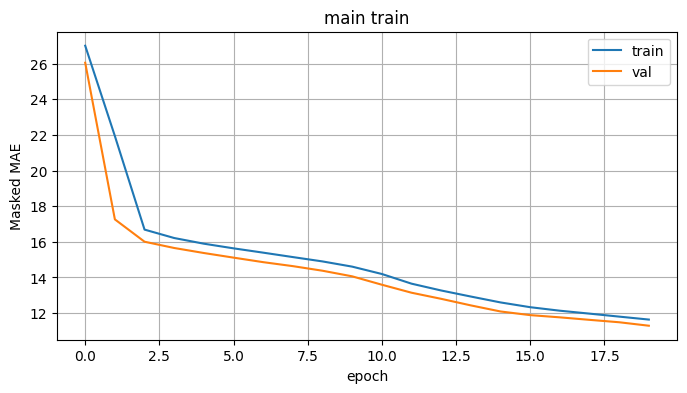

In [ ]:
# ===============================================================
# 0.  Drive, imports, global constants
# ===============================================================
from google.colab import drive
drive.mount('/content/drive')

import tensorflow as tf, numpy as np, matplotlib.pyplot as plt
from tensorflow.keras import layers, Model
from sklearn.model_selection import train_test_split
import glob, os, time

# ---------- hyper-params ----------
TARGET_SIZE  = (384, 1248)      # (H, W)
BATCH_SIZE   = 2
VAL_SPLIT    = 0.20
MAX_DISP     = 192              # covers KITTI / Scene-Flow
N_SHOW       = 5                # how many *batches* to visualise
SAVE_DIR     = "/content/drive/MyDrive/hitnet_vis"

# pick the stereo feature extractor here:  "lite" | "unet" | "mobilenet"
BACKBONE_TYPE = "mobilenet"

LEFT_DIR  = "/content/drive/MyDrive/EE 417/data-scene-flow/training/image_2"
RIGHT_DIR = "/content/drive/MyDrive/EE 417/data-scene-flow/training/image_3"
GT_DIR    = "/content/drive/MyDrive/EE 417/data-scene-flow/training/disp_occ_0"

# ===============================================================
# 1.  Data helpers
# ===============================================================
def load_rgb(fp):
    img = tf.image.decode_png(tf.io.read_file(fp), channels=3)
    return tf.image.convert_image_dtype(img, tf.float32)

def load_disp(fp):
    raw = tf.image.decode_png(tf.io.read_file(fp), channels=1, dtype=tf.uint16)
    return tf.cast(raw, tf.float32) / 256.0          # KITTI scale factor

def list_png(folder):
    """{basename: full_path} for every PNG in *folder*."""
    return {os.path.basename(p): p for p in glob.glob(f"{folder}/*.png")}

# ----------------------------------------------------------------
def make_datasets():
    L_all, R_all, G_all = list_png(LEFT_DIR), list_png(RIGHT_DIR), list_png(GT_DIR)
    keys = sorted([k for k in L_all if k in R_all and k in G_all])
    tr_keys, va_keys = train_test_split(keys, test_size=VAL_SPLIT, random_state=42)

    def build(keys):
        l_paths = tf.constant([L_all[k] for k in keys])
        r_paths = tf.constant([R_all[k] for k in keys])
        g_paths = tf.constant([G_all[k] for k in keys])

        def _parse(l, r, g):
            Limg = tf.image.resize(load_rgb(l),  TARGET_SIZE)
            Rimg = tf.image.resize(load_rgb(r),  TARGET_SIZE)
            Dimg = tf.image.resize(load_disp(g), TARGET_SIZE, method='nearest')
            return (Limg, Rimg), Dimg

        return (tf.data.Dataset.from_tensor_slices((l_paths, r_paths, g_paths))
                .map(_parse, tf.data.AUTOTUNE)
                .batch(BATCH_SIZE)
                .prefetch(tf.data.AUTOTUNE))

    return build(tr_keys), build(va_keys)

train_ds, val_ds = make_datasets()

# ===============================================================
# 2.  Backbones   (lite  |  unet  |  mobilenet)
# ===============================================================
def conv_block(x, ch, k=3):
    """Two Conv → BN → ReLU layers (U-Net helper)."""
    for _ in range(2):
        x = layers.Conv2D(ch, k, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
    return x

# ----- U-Net backbone ---------------------------------------------------------
def unet_backbone(base=32, depth=4):
    inp, skips = layers.Input(shape=(None, None, 3)), []
    x = inp
    # encoder
    for d in range(depth):
        x = conv_block(x, base * 2**d)
        skips.append(x)
        x = layers.MaxPool2D(2)(x)
    # bottleneck
    x = conv_block(x, base * 2**depth)
    # decoder
    for d in reversed(range(depth)):
        x = layers.Conv2DTranspose(base * 2**d, 2, 2, padding='same')(x)
        x = layers.Concatenate()([x, skips[d]])
        x = conv_block(x, base * 2**d)
    out = layers.Conv2D(base, 1, padding='same', activation='relu')(x)
    return Model(inp, out, name="UNetBackbone")

# ----- original tiny backbone -------------------------------------------------
def lite_backbone(base=16):
    inp = layers.Input(shape=(None, None, 3))
    x1  = layers.Conv2D(base,   3, 2, padding='same', activation='relu')(inp)
    x2  = layers.Conv2D(base*2, 3, 2, padding='same', activation='relu')(x1)
    x2  = layers.Conv2D(base*2, 3, 1, padding='same', activation='relu')(x2)
    up  = layers.Conv2DTranspose(base, 3, 2, padding='same', activation='relu')(x2)
    up  = layers.Lambda(lambda t: t[0][:, :tf.shape(t[1])[1],
                                          :tf.shape(t[1])[2], :])([up, x1])
    up  = layers.Concatenate()([up, x1])
    up  = layers.Conv2DTranspose(base, 3, 2, padding='same', activation='relu')(up)
    out = layers.Conv2D(base, 3, padding='same', activation='relu')(up)
    return Model(inp, out, name="LiteBackbone")

# ----- MobileNet-V2 backbone --------------------------------------------------
def mobilenet_backbone(width=0.75):
    from tensorflow.keras.applications import MobileNetV2
    base_model = MobileNetV2(include_top=False,
                             input_shape=(None, None, 3),
                             alpha=width,
                             weights=None)
    # Use an earlier layer to get larger feature maps
    feat = base_model.get_layer('block_6_expand_relu').output  # stride 8
    out  = layers.Conv2D(32, 1, padding='same', activation='relu')(feat)
    return Model(base_model.input, out, name="MobileNetBackbone")


# ===============================================================
# 2b.  Init & Propagation modules (unchanged)
# ===============================================================
class InitLayer(layers.Layer):
    def __init__(self, D=MAX_DISP):
        super().__init__()
        self.D = D

    def call(self, feats):
        FL, FR = feats
        B, H, W, C = tf.shape(FR)[0], tf.shape(FR)[1], tf.shape(FR)[2], tf.shape(FR)[3]
        max_disp = tf.minimum(self.D, W)  # to avoid shifting beyond bounds

        cost_vol = []
        for d in range(self.D):
            # use tf.roll and mask to zero out invalid regions
            shifted = tf.roll(FR, shift=-d, axis=2)  # shift left by d pixels
            # create a mask to zero out wrapped-around parts
            valid_mask = tf.sequence_mask(W - d, W)  # shape [W], True for valid
            valid_mask = tf.reshape(valid_mask, (1, 1, W, 1))  # broadcastable
            valid_mask = tf.cast(valid_mask, tf.float32)
            shifted = shifted * valid_mask  # mask wrapped values to 0

            diff = tf.reduce_mean(tf.abs(FL - shifted), axis=-1, keepdims=True)
            cost_vol.append(diff)

        volume = tf.concat(cost_vol, axis=-1)  # shape: (B, H, W, D)
        disp0 = tf.cast(tf.argmin(volume, axis=-1), tf.float32)[..., None]
        return disp0


class PropLayer(layers.Layer):
    def __init__(self):
        super().__init__()
        self.c1 = layers.Conv2D(32, 3, padding='same', activation='relu')
        self.c2 = layers.Conv2D(1,  3, padding='same')
    def warp(self, FR, D):
        B, H, W, _ = tf.unstack(tf.shape(FR))
        D_res = tf.image.resize(D, [H, W], 'bilinear')
        grid_x = tf.tile(tf.reshape(tf.range(W, dtype=tf.float32),
                                    (1,1,W,1)), [B, H, 1, 1])
        xs = tf.round(grid_x - D_res)
        xs = tf.clip_by_value(xs, 0.0, tf.cast(W-1, tf.float32))
        idx = tf.stack([
            tf.tile(tf.reshape(tf.range(B), [-1,1,1]), [1,H,W]),
            tf.tile(tf.reshape(tf.range(H), [1,-1,1]), [B,1,W]),
            tf.cast(xs[...,0], tf.int32)
        ], axis=-1)
        return tf.gather_nd(FR, idx)
    def call(self, inputs):
        FL, FR, D0 = inputs
        WR  = self.warp(FR, D0)
        D0u = tf.image.resize(D0, tf.shape(FL)[1:3], 'bilinear')
        x   = self.c1(tf.concat([FL, WR, D0u], axis=-1))
        return D0u + self.c2(x)

# ===============================================================
# 2c.  HITNet wrapper with pluggable backbone
# ===============================================================
class HITNet(Model):
    def __init__(self, backbone_type="lite"):
        super().__init__()
        if   backbone_type == "unet":
            self.bb = unet_backbone(base=32)
        elif backbone_type == "mobilenet":
            self.bb = mobilenet_backbone(width=0.75)
        else:
            self.bb = lite_backbone()
        self.init = InitLayer()
        self.prop = PropLayer()
    #def call(self, inputs):
     #   L, R = inputs
      #  FL, FR = self.bb(L), self.bb(R)
     #   D0 = self.init([FL, FR])
      #  return self.prop([FL, FR, D0])

    def call(self, inputs):
        L, R = inputs
        FL, FR = self.bb(L), self.bb(R)
        D0 = self.init([FL, FR])
        D1 = self.prop([FL, FR, D0])
        # Upsample disparity prediction to match GT shape
        D1_up = tf.image.resize(D1, tf.shape(L)[1:3], method='bilinear')  # (H, W)
        return D1_up


# ===============================================================
# 3.  Masked-MAE loss (ignore GT == 0)
# ===============================================================
def masked_mae(y_true, y_pred):
    mask = tf.cast(y_true > 0.0, tf.float32)
    err  = tf.abs(y_true - y_pred) * mask
    return tf.reduce_sum(err) / tf.reduce_sum(mask)

# ===============================================================
# 4.  KITTI metrics + evaluation
# ===============================================================
def kitti_d1_all(pred, gt):
    mask  = tf.cast(gt > 0.0, tf.float32)
    abs_e = tf.abs(pred - gt)
    rel_e = abs_e / tf.maximum(gt, 1e-6)
    bad   = tf.logical_and(abs_e > 3.0, rel_e > 0.05)
    bad   = tf.cast(bad, tf.float32) * mask
    return tf.reduce_sum(bad), tf.reduce_sum(mask)

def mae_rmse(pred, gt):
    mask  = tf.cast(gt > 0.0, tf.float32)
    abs_e = tf.abs(pred - gt) * mask
    sqe   = tf.square(pred - gt) * mask
    return tf.reduce_sum(abs_e), tf.reduce_sum(sqe), tf.reduce_sum(mask)

def evaluate(model, dataset):
    mae_sum = sqe_sum = bad_sum = pix_sum = img_cnt = 0.0
    start   = time.perf_counter()
    for (L, R), GT in dataset:
        pred = model([L, R], training=False)[..., 0]
        gt   = GT[..., 0]
        ae, se, valid = mae_rmse(pred, gt)
        bad, _        = kitti_d1_all(pred, gt)
        mae_sum += ae.numpy(); sqe_sum += se.numpy()
        bad_sum += bad.numpy(); pix_sum += valid.numpy()
        img_cnt += int(L.shape[0])
    sec_pair = (time.perf_counter() - start) / img_cnt
    mae      = mae_sum / pix_sum
    rmse     = np.sqrt(sqe_sum / pix_sum)
    d1       = (bad_sum / pix_sum) * 100.0
    return sec_pair, d1, mae, rmse

# ===============================================================
# 5.  Train → fine-tune → evaluate
# ===============================================================
def plot_loss(hist, title):
    plt.figure(figsize=(8,4))
    plt.plot(hist.history['loss'], label='train')
    plt.plot(hist.history['val_loss'], label='val')
    plt.xlabel('epoch'); plt.ylabel('Masked MAE')
    plt.title(title); plt.grid(); plt.legend(); plt.show()

model = HITNet(backbone_type=BACKBONE_TYPE)
#_ = model((tf.zeros((1, *TARGET_SIZE, 3)),) * 2)   # build weights
_ = model((tf.zeros((1, *TARGET_SIZE, 3)), tf.zeros((1, *TARGET_SIZE, 3))))


# ----- main training -----
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss=masked_mae)
hist = model.fit(train_ds, validation_data=val_ds, epochs=20)
plot_loss(hist, "main train")


Epoch 1/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 64s 399ms/step - loss: 11.6207 - val_loss: 11.1338
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 51s 191ms/step - loss: 11.5604 - val_loss: 11.1119
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 18s 158ms/step - loss: 11.5386 - val_loss: 11.0991
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 18s 127ms/step - loss: 11.5179 - val_loss: 11.0894
Epoch 5/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 21s 132ms/step - loss: 11.5044 - val_loss: 11.0750
Epoch 6/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 114ms/step - loss: 11.4912 - val_loss: 11.0564
Epoch 7/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 11s 118ms/step - loss: 11.4747 - val_loss: 11.0401
Epoch 8/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - loss: 11.4573 - val_loss: 11.0216
Epoch 9/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 19s 124ms/step - loss: 11.4398 - val_loss: 11.0107
Epoch 10/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 101ms/step - loss: 11.4202 - val_loss: 10.9939


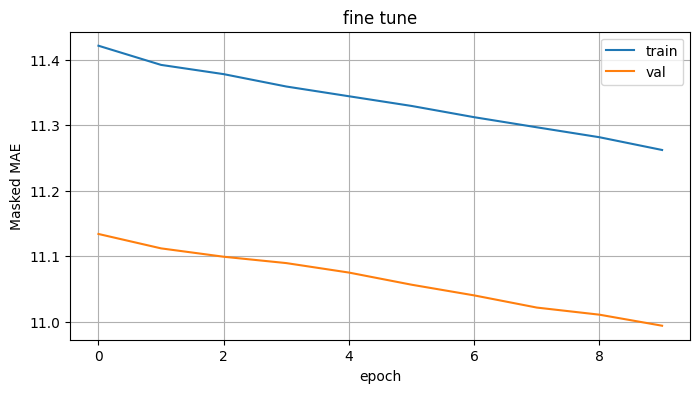

In [ ]:

# ----- fine-tune -----
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss=masked_mae)
hist_ft = model.fit(train_ds, validation_data=val_ds, epochs=10)
plot_loss(hist_ft, "fine tune")


In [ ]:
# ----- final evaluation -----
sec, d1, mae, rmse = evaluate(model, val_ds)
print(f"Disparity computation time: {sec:.2f}s")
print(f"KITTI D1-all error       = {d1:.2f}%")
print(f"MAE: {mae:.2f} px | RMSE: {rmse:.2f} px")

Disparity computation time: 0.30s
KITTI D1-all error       = 82.00%
MAE: 11.04 px | RMSE: 14.44 px


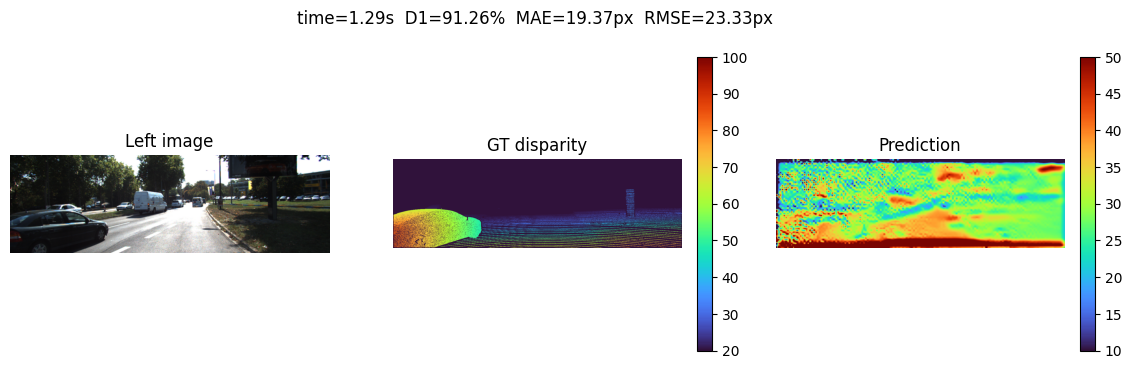

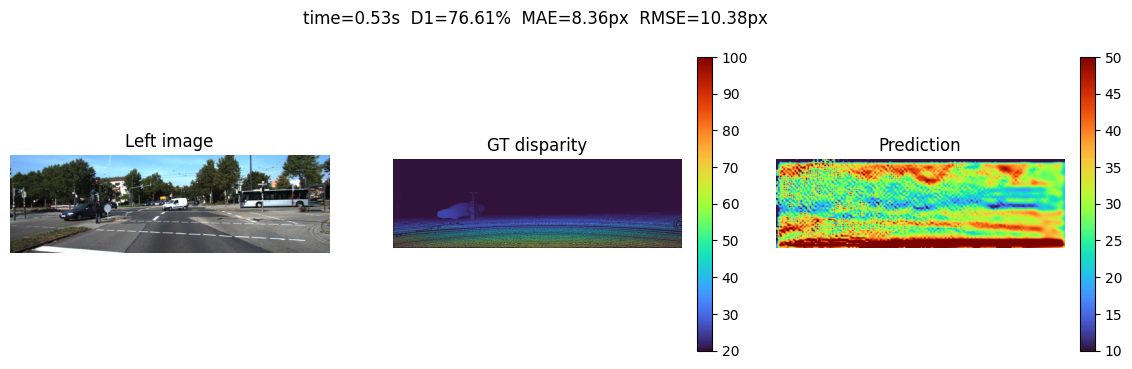

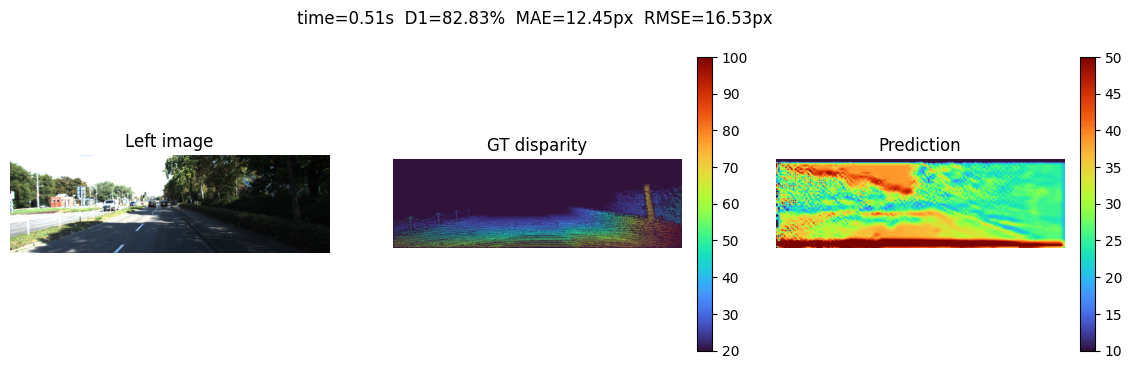

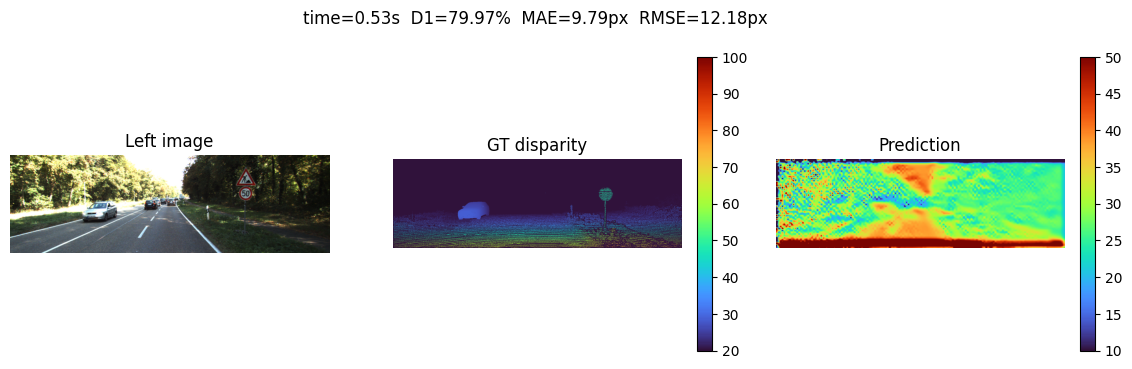

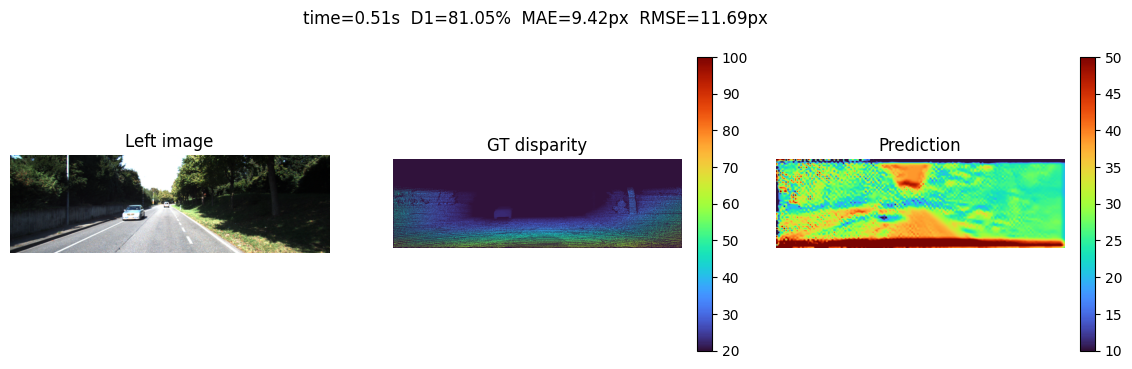

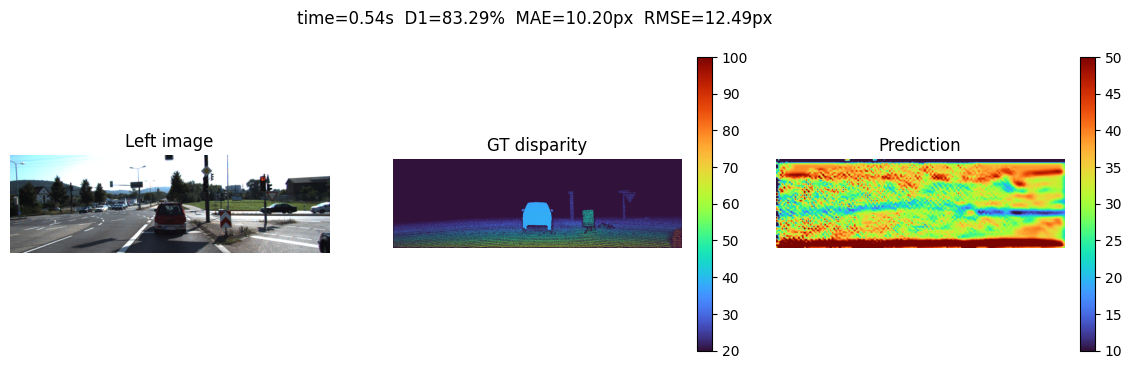

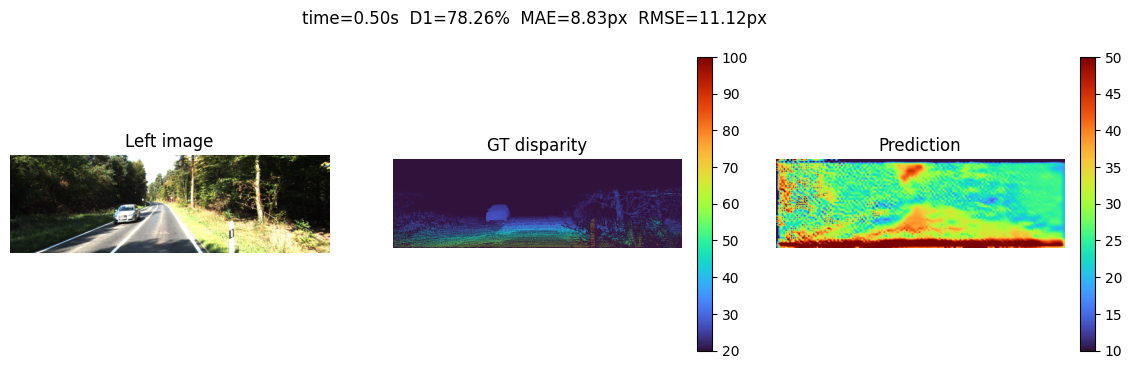

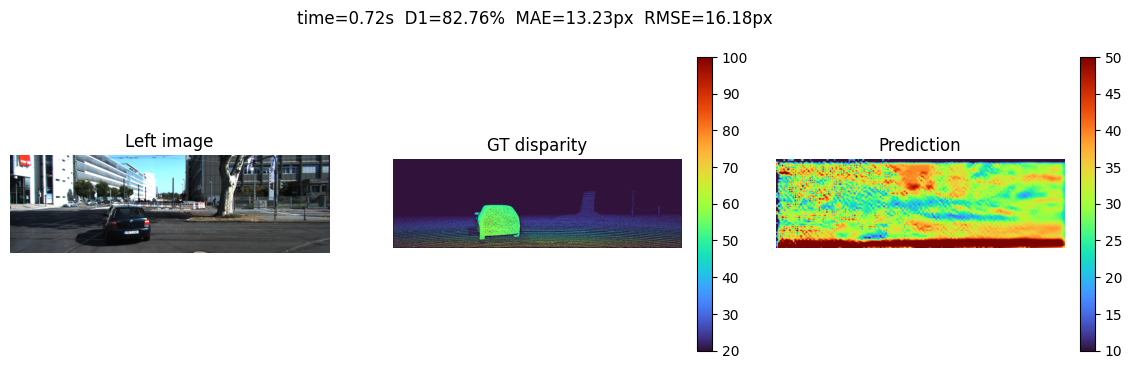

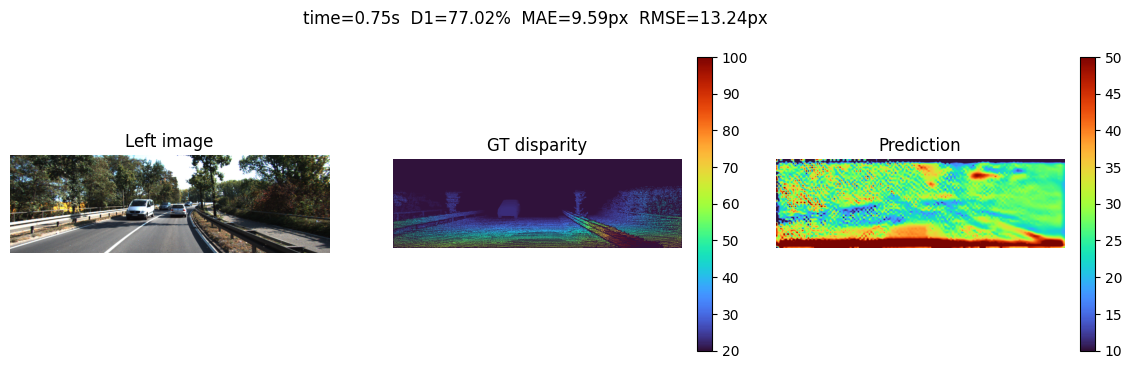

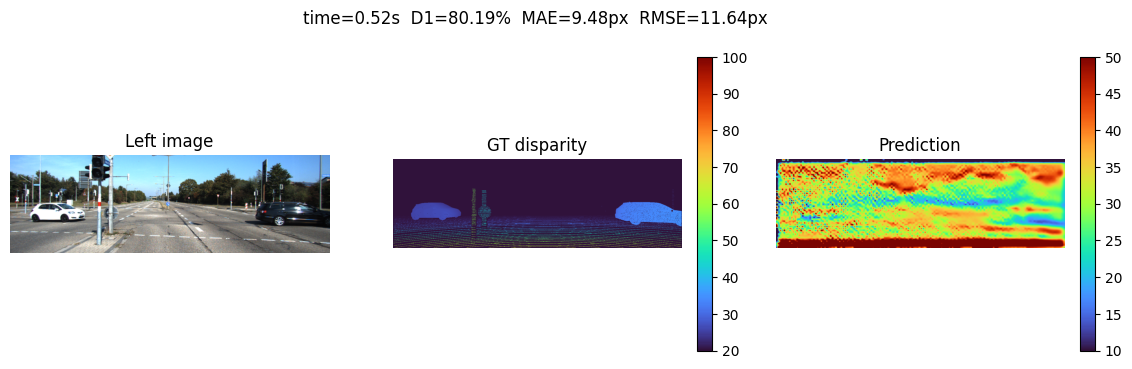

In [ ]:
#vmin, vmax = 20, 50  # consistent for both GT and Prediction

os.makedirs(SAVE_DIR, exist_ok=True)
batch_counter = 0

for (Ls, Rs), Ds in val_ds.take(N_SHOW):
    preds = model([Ls, Rs], training=False)[..., 0].numpy()
    for img_idx in range(Ls.shape[0]):
        single_ds = tf.data.Dataset.from_tensor_slices(
            ((Ls[img_idx][None], Rs[img_idx][None]), Ds[img_idx][None])
        ).batch(1)
        t_img, d1_img, mae_img, rmse_img = evaluate(model, single_ds)

        fig, ax = plt.subplots(1, 3, figsize=(14, 4))

        ax[0].imshow(Ls[img_idx])
        ax[0].set_title("Left image")
        ax[0].axis("off")

        im2 = ax[1].imshow(Ds[img_idx, ..., 0], cmap='turbo', vmin=20, vmax=100)
        ax[1].set_title("GT disparity")
        ax[1].axis("off")
        fig.colorbar(im2, ax=ax[1], fraction=0.046)

        im3 = ax[2].imshow(preds[img_idx], cmap='turbo', vmin=10, vmax=50)
        ax[2].set_title("Prediction")
        ax[2].axis("off")
        fig.colorbar(im3, ax=ax[2], fraction=0.046)

        fig.suptitle(f"time={t_img:.2f}s  D1={d1_img:.2f}%  MAE={mae_img:.2f}px  RMSE={rmse_img:.2f}px")
        fig.savefig(f"{SAVE_DIR}/sample_{batch_counter}_{img_idx}.png", dpi=150, bbox_inches="tight")
        plt.show()
        plt.close(fig)

    batch_counter += 1


### HITNet with Custom Lite Feature Extractor

Mounted at /content/drive
Epoch 1/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 154s 1s/step - loss: 52.2969 - val_loss: 41.8615
Epoch 2/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 22s 277ms/step - loss: 35.3481 - val_loss: 24.8452
Epoch 3/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 22s 277ms/step - loss: 24.2214 - val_loss: 23.2788
Epoch 4/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 41s 278ms/step - loss: 22.8566 - val_loss: 21.9466
Epoch 5/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 41s 280ms/step - loss: 21.6255 - val_loss: 20.5820
Epoch 6/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 39s 255ms/step - loss: 20.2784 - val_loss: 19.0176
Epoch 7/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 41s 262ms/step - loss: 18.7402 - val_loss: 17.6885
Epoch 8/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 23s 284ms/step - loss: 17.6342 - val_loss: 16.9889
Epoch 9/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 41s 281ms/step - loss: 17.0526 - val_loss: 16.4546
Epoch 10/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 39s 258ms/step - loss: 16.5595 - val_loss: 16.0309
Epoch 11/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 43s 282ms/step - loss: 16.1634 - val_loss: 15.

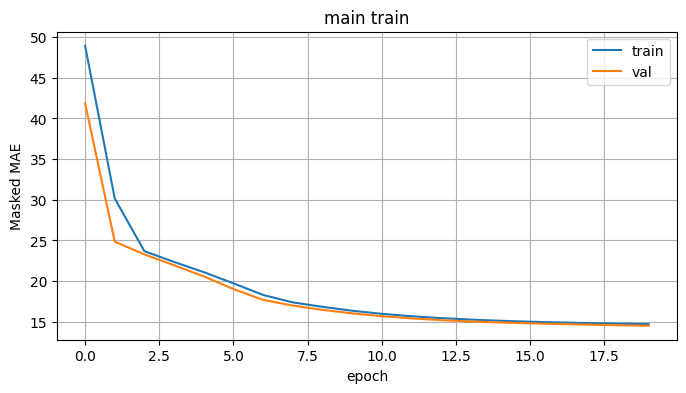

In [ ]:
# ===============================================================
# 0.  Drive, imports, global constants
# ===============================================================
from google.colab import drive
drive.mount('/content/drive')

import tensorflow as tf, numpy as np, matplotlib.pyplot as plt
from tensorflow.keras import layers, Model
from sklearn.model_selection import train_test_split
import glob, os, time

# ---------- hyper-params ----------
TARGET_SIZE  = (384, 1248)      # (H, W)
BATCH_SIZE   = 2
VAL_SPLIT    = 0.20
MAX_DISP     = 192              # covers KITTI / Scene-Flow
N_SHOW       = 5                # how many *batches* to visualise
SAVE_DIR     = "/content/drive/MyDrive/hitnet_vis"

# pick the stereo feature extractor here:  "lite" | "unet" | "mobilenet"
BACKBONE_TYPE = "lite"

LEFT_DIR  = "/content/drive/MyDrive/EE 417/data-scene-flow/training/image_2"
RIGHT_DIR = "/content/drive/MyDrive/EE 417/data-scene-flow/training/image_3"
GT_DIR    = "/content/drive/MyDrive/EE 417/data-scene-flow/training/disp_occ_0"

# ===============================================================
# 1.  Data helpers
# ===============================================================
def load_rgb(fp):
    img = tf.image.decode_png(tf.io.read_file(fp), channels=3)
    return tf.image.convert_image_dtype(img, tf.float32)

def load_disp(fp):
    raw = tf.image.decode_png(tf.io.read_file(fp), channels=1, dtype=tf.uint16)
    return tf.cast(raw, tf.float32) / 256.0          # KITTI scale factor

def list_png(folder):
    """{basename: full_path} for every PNG in *folder*."""
    return {os.path.basename(p): p for p in glob.glob(f"{folder}/*.png")}

# ----------------------------------------------------------------
def make_datasets():
    L_all, R_all, G_all = list_png(LEFT_DIR), list_png(RIGHT_DIR), list_png(GT_DIR)
    keys = sorted([k for k in L_all if k in R_all and k in G_all])
    tr_keys, va_keys = train_test_split(keys, test_size=VAL_SPLIT, random_state=42)

    def build(keys):
        l_paths = tf.constant([L_all[k] for k in keys])
        r_paths = tf.constant([R_all[k] for k in keys])
        g_paths = tf.constant([G_all[k] for k in keys])

        def _parse(l, r, g):
            Limg = tf.image.resize(load_rgb(l),  TARGET_SIZE)
            Rimg = tf.image.resize(load_rgb(r),  TARGET_SIZE)
            Dimg = tf.image.resize(load_disp(g), TARGET_SIZE, method='nearest')
            return (Limg, Rimg), Dimg

        return (tf.data.Dataset.from_tensor_slices((l_paths, r_paths, g_paths))
                .map(_parse, tf.data.AUTOTUNE)
                .batch(BATCH_SIZE)
                .prefetch(tf.data.AUTOTUNE))

    return build(tr_keys), build(va_keys)

train_ds, val_ds = make_datasets()

# ===============================================================
# 2.  Backbones   (lite  |  unet  |  mobilenet)
# ===============================================================
def conv_block(x, ch, k=3):
    """Two Conv → BN → ReLU layers (U-Net helper)."""
    for _ in range(2):
        x = layers.Conv2D(ch, k, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
    return x

# ----- U-Net backbone ---------------------------------------------------------
def unet_backbone(base=32, depth=4):
    inp, skips = layers.Input(shape=(None, None, 3)), []
    x = inp
    # encoder
    for d in range(depth):
        x = conv_block(x, base * 2**d)
        skips.append(x)
        x = layers.MaxPool2D(2)(x)
    # bottleneck
    x = conv_block(x, base * 2**depth)
    # decoder
    for d in reversed(range(depth)):
        x = layers.Conv2DTranspose(base * 2**d, 2, 2, padding='same')(x)
        x = layers.Concatenate()([x, skips[d]])
        x = conv_block(x, base * 2**d)
    out = layers.Conv2D(base, 1, padding='same', activation='relu')(x)
    return Model(inp, out, name="UNetBackbone")

# ----- original tiny backbone -------------------------------------------------
def lite_backbone(base=16):
    inp = layers.Input(shape=(None, None, 3))
    x1  = layers.Conv2D(base,   3, 2, padding='same', activation='relu')(inp)
    x2  = layers.Conv2D(base*2, 3, 2, padding='same', activation='relu')(x1)
    x2  = layers.Conv2D(base*2, 3, 1, padding='same', activation='relu')(x2)
    up  = layers.Conv2DTranspose(base, 3, 2, padding='same', activation='relu')(x2)
    up  = layers.Lambda(lambda t: t[0][:, :tf.shape(t[1])[1],
                                          :tf.shape(t[1])[2], :])([up, x1])
    up  = layers.Concatenate()([up, x1])
    up  = layers.Conv2DTranspose(base, 3, 2, padding='same', activation='relu')(up)
    out = layers.Conv2D(base, 3, padding='same', activation='relu')(up)
    return Model(inp, out, name="LiteBackbone")

# ----- MobileNet-V2 backbone --------------------------------------------------
def mobilenet_backbone(width=0.75):
    from tensorflow.keras.applications import MobileNetV2
    base_model = MobileNetV2(include_top=False,
                             input_shape=(None, None, 3),
                             alpha=width,
                             weights=None)
    # Use an earlier layer to get larger feature maps
    feat = base_model.get_layer('block_6_expand_relu').output  # stride 8
    out  = layers.Conv2D(32, 1, padding='same', activation='relu')(feat)
    return Model(base_model.input, out, name="MobileNetBackbone")


# ===============================================================
# 2b.  Init & Propagation modules (unchanged)
# ===============================================================
class InitLayer(layers.Layer):
    def __init__(self, D=MAX_DISP):
        super().__init__()
        self.D = D

    def call(self, feats):
        FL, FR = feats
        B, H, W, C = tf.shape(FR)[0], tf.shape(FR)[1], tf.shape(FR)[2], tf.shape(FR)[3]
        max_disp = tf.minimum(self.D, W)  # to avoid shifting beyond bounds

        cost_vol = []
        for d in range(self.D):
            # use tf.roll and mask to zero out invalid regions
            shifted = tf.roll(FR, shift=-d, axis=2)  # shift left by d pixels
            # create a mask to zero out wrapped-around parts
            valid_mask = tf.sequence_mask(W - d, W)  # shape [W], True for valid
            valid_mask = tf.reshape(valid_mask, (1, 1, W, 1))  # broadcastable
            valid_mask = tf.cast(valid_mask, tf.float32)
            shifted = shifted * valid_mask  # mask wrapped values to 0

            diff = tf.reduce_mean(tf.abs(FL - shifted), axis=-1, keepdims=True)
            cost_vol.append(diff)

        volume = tf.concat(cost_vol, axis=-1)  # shape: (B, H, W, D)
        disp0 = tf.cast(tf.argmin(volume, axis=-1), tf.float32)[..., None]
        return disp0


class PropLayer(layers.Layer):
    def __init__(self):
        super().__init__()
        self.c1 = layers.Conv2D(32, 3, padding='same', activation='relu')
        self.c2 = layers.Conv2D(1,  3, padding='same')
    def warp(self, FR, D):
        B, H, W, _ = tf.unstack(tf.shape(FR))
        D_res = tf.image.resize(D, [H, W], 'bilinear')
        grid_x = tf.tile(tf.reshape(tf.range(W, dtype=tf.float32),
                                    (1,1,W,1)), [B, H, 1, 1])
        xs = tf.round(grid_x - D_res)
        xs = tf.clip_by_value(xs, 0.0, tf.cast(W-1, tf.float32))
        idx = tf.stack([
            tf.tile(tf.reshape(tf.range(B), [-1,1,1]), [1,H,W]),
            tf.tile(tf.reshape(tf.range(H), [1,-1,1]), [B,1,W]),
            tf.cast(xs[...,0], tf.int32)
        ], axis=-1)
        return tf.gather_nd(FR, idx)
    def call(self, inputs):
        FL, FR, D0 = inputs
        WR  = self.warp(FR, D0)
        D0u = tf.image.resize(D0, tf.shape(FL)[1:3], 'bilinear')
        x   = self.c1(tf.concat([FL, WR, D0u], axis=-1))
        return D0u + self.c2(x)

# ===============================================================
# 2c.  HITNet wrapper with pluggable backbone
# ===============================================================
class HITNet(Model):
    def __init__(self, backbone_type="lite"):
        super().__init__()
        if   backbone_type == "unet":
            self.bb = unet_backbone(base=32)
        elif backbone_type == "mobilenet":
            self.bb = mobilenet_backbone(width=0.75)
        else:
            self.bb = lite_backbone()
        self.init = InitLayer()
        self.prop = PropLayer()
    #def call(self, inputs):
     #   L, R = inputs
      #  FL, FR = self.bb(L), self.bb(R)
     #   D0 = self.init([FL, FR])
      #  return self.prop([FL, FR, D0])

    def call(self, inputs):
        L, R = inputs
        FL, FR = self.bb(L), self.bb(R)
        D0 = self.init([FL, FR])
        D1 = self.prop([FL, FR, D0])
        # Upsample disparity prediction to match GT shape
        D1_up = tf.image.resize(D1, tf.shape(L)[1:3], method='bilinear')  # (H, W)
        return D1_up


# ===============================================================
# 3.  Masked-MAE loss (ignore GT == 0)
# ===============================================================
def masked_mae(y_true, y_pred):
    mask = tf.cast(y_true > 0.0, tf.float32)
    err  = tf.abs(y_true - y_pred) * mask
    return tf.reduce_sum(err) / tf.reduce_sum(mask)

# ===============================================================
# 4.  KITTI metrics + evaluation
# ===============================================================
def kitti_d1_all(pred, gt):
    mask  = tf.cast(gt > 0.0, tf.float32)
    abs_e = tf.abs(pred - gt)
    rel_e = abs_e / tf.maximum(gt, 1e-6)
    bad   = tf.logical_and(abs_e > 3.0, rel_e > 0.05)
    bad   = tf.cast(bad, tf.float32) * mask
    return tf.reduce_sum(bad), tf.reduce_sum(mask)

def mae_rmse(pred, gt):
    mask  = tf.cast(gt > 0.0, tf.float32)
    abs_e = tf.abs(pred - gt) * mask
    sqe   = tf.square(pred - gt) * mask
    return tf.reduce_sum(abs_e), tf.reduce_sum(sqe), tf.reduce_sum(mask)

def evaluate(model, dataset):
    mae_sum = sqe_sum = bad_sum = pix_sum = img_cnt = 0.0
    start   = time.perf_counter()
    for (L, R), GT in dataset:
        pred = model([L, R], training=False)[..., 0]
        gt   = GT[..., 0]
        ae, se, valid = mae_rmse(pred, gt)
        bad, _        = kitti_d1_all(pred, gt)
        mae_sum += ae.numpy(); sqe_sum += se.numpy()
        bad_sum += bad.numpy(); pix_sum += valid.numpy()
        img_cnt += int(L.shape[0])
    sec_pair = (time.perf_counter() - start) / img_cnt
    mae      = mae_sum / pix_sum
    rmse     = np.sqrt(sqe_sum / pix_sum)
    d1       = (bad_sum / pix_sum) * 100.0
    return sec_pair, d1, mae, rmse

# ===============================================================
# 5.  Train → fine-tune → evaluate
# ===============================================================
def plot_loss(hist, title):
    plt.figure(figsize=(8,4))
    plt.plot(hist.history['loss'], label='train')
    plt.plot(hist.history['val_loss'], label='val')
    plt.xlabel('epoch'); plt.ylabel('Masked MAE')
    plt.title(title); plt.grid(); plt.legend(); plt.show()

model = HITNet(backbone_type=BACKBONE_TYPE)
#_ = model((tf.zeros((1, *TARGET_SIZE, 3)),) * 2)   # build weights
_ = model((tf.zeros((1, *TARGET_SIZE, 3)), tf.zeros((1, *TARGET_SIZE, 3))))


# ----- main training -----
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss=masked_mae)
hist = model.fit(train_ds, validation_data=val_ds, epochs=20)
plot_loss(hist, "main train")


Epoch 1/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 76s 520ms/step - loss: 14.7584 - val_loss: 14.2298
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 38s 283ms/step - loss: 14.6693 - val_loss: 14.2196
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 39s 258ms/step - loss: 14.6611 - val_loss: 14.2117
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 41s 257ms/step - loss: 14.6546 - val_loss: 14.2056
Epoch 5/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 23s 284ms/step - loss: 14.6489 - val_loss: 14.1998
Epoch 6/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 41s 280ms/step - loss: 14.6432 - val_loss: 14.1931
Epoch 7/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 21s 258ms/step - loss: 14.6381 - val_loss: 14.1870
Epoch 8/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 43s 281ms/step - loss: 14.6322 - val_loss: 14.1812
Epoch 9/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 41s 285ms/step - loss: 14.6274 - val_loss: 14.1754
Epoch 10/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 39s 256ms/step - loss: 14.6214 - val_loss: 14.1698


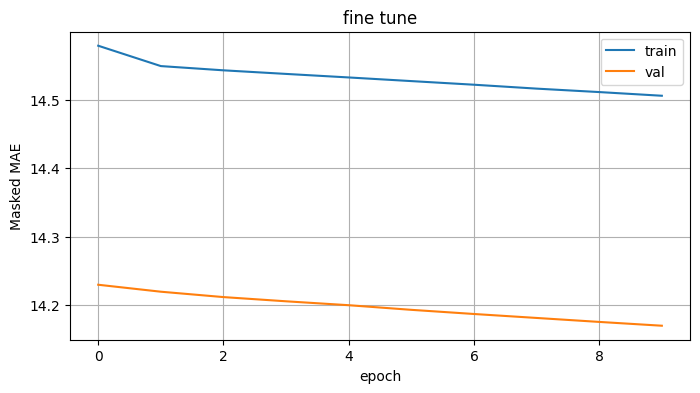

In [ ]:

# ----- fine-tune -----
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss=masked_mae)
hist_ft = model.fit(train_ds, validation_data=val_ds, epochs=10)
plot_loss(hist_ft, "fine tune")


In [ ]:
# ----- final evaluation -----
sec, d1, mae, rmse = evaluate(model, val_ds)
print(f"Disparity computation time: {sec:.2f}s")
print(f"KITTI D1-all error       = {d1:.2f}%")
print(f"MAE: {mae:.2f} px | RMSE: {rmse:.2f} px")

Disparity computation time: 0.65s
KITTI D1-all error       = 88.35%
MAE: 14.20 px | RMSE: 17.39 px


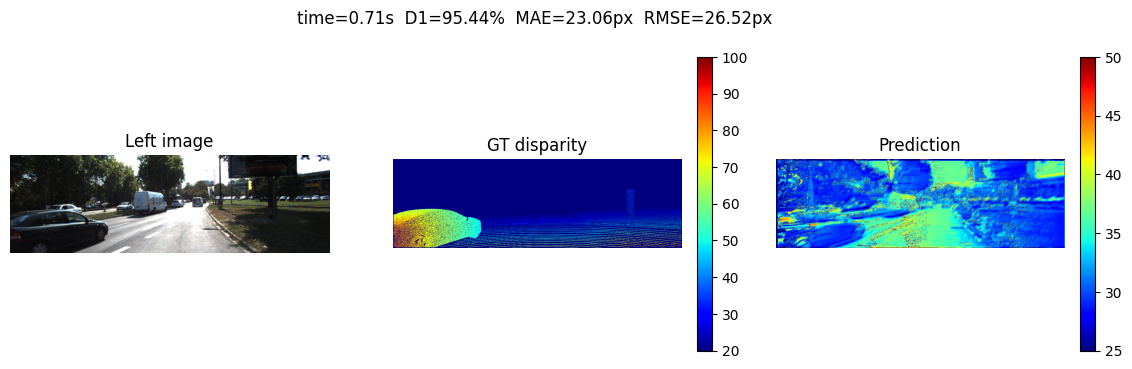

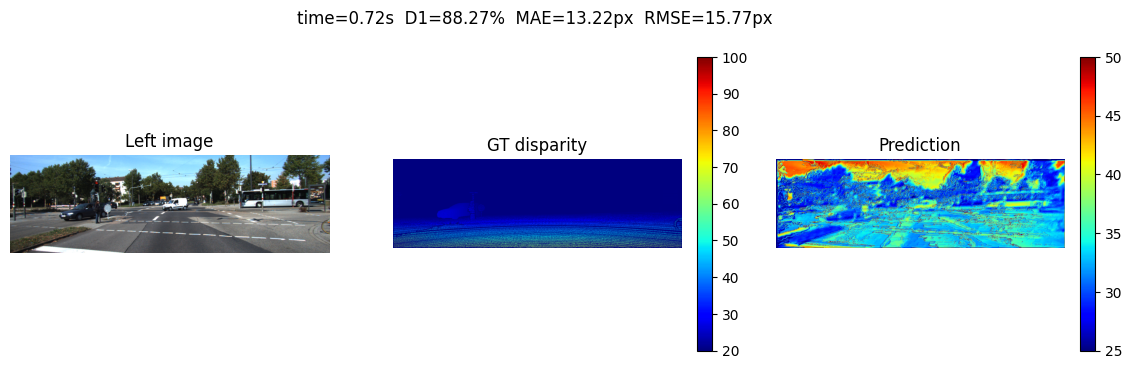

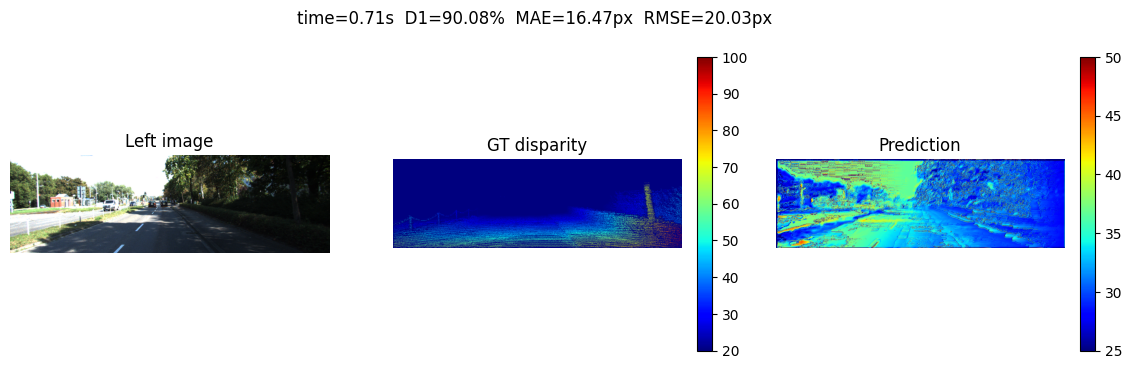

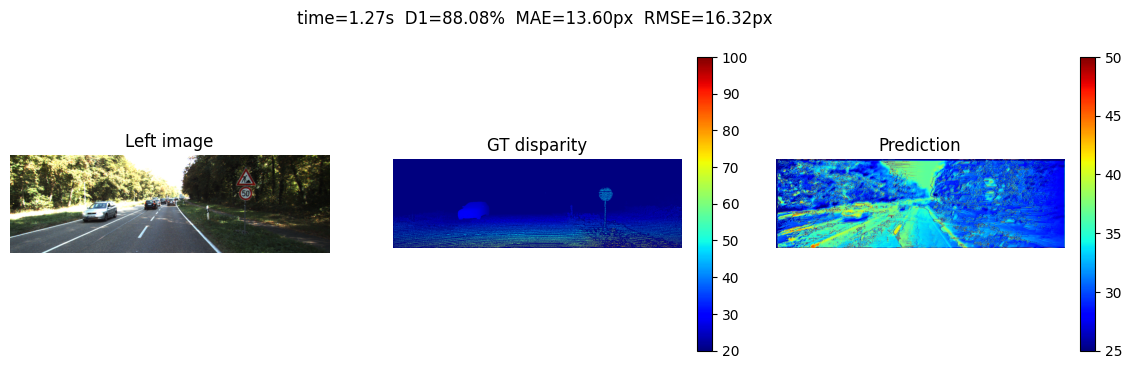

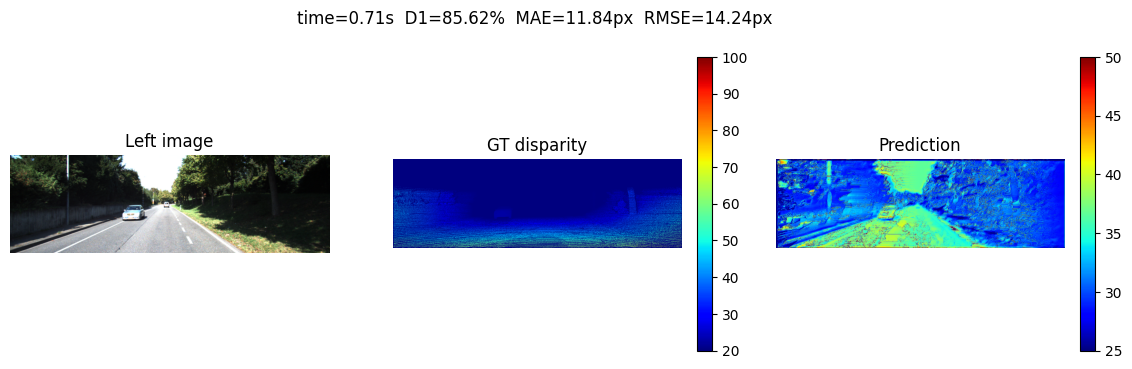

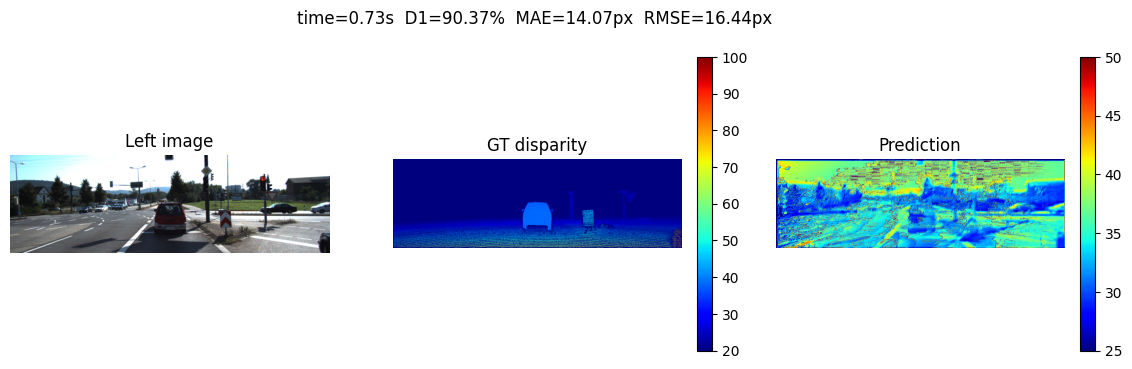

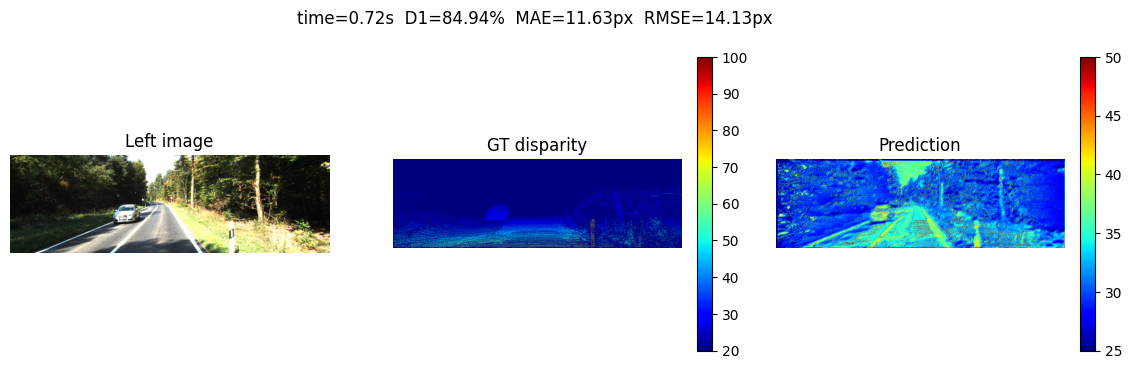

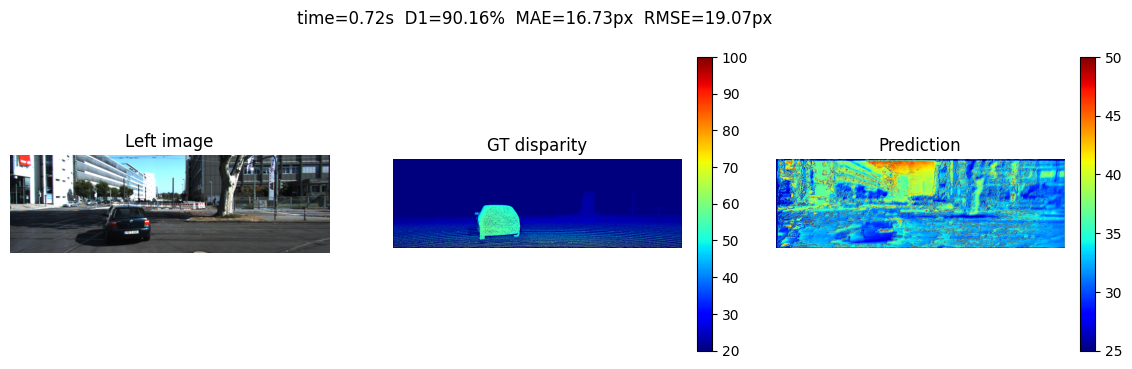

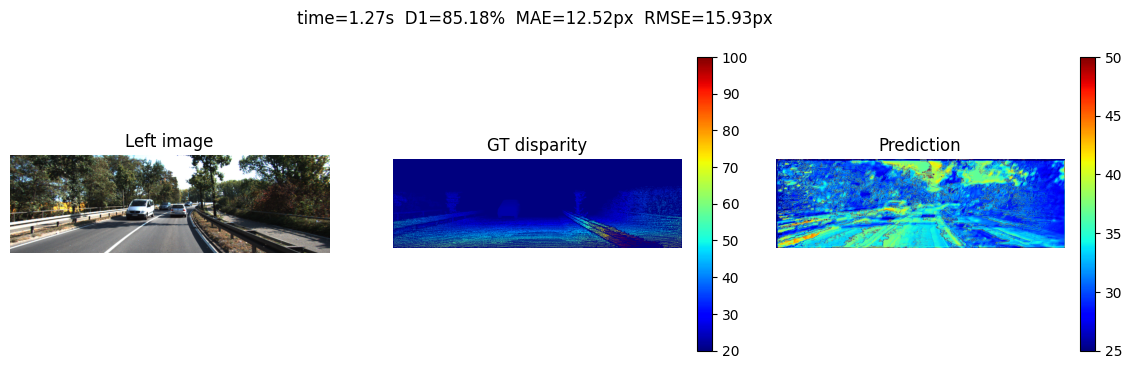

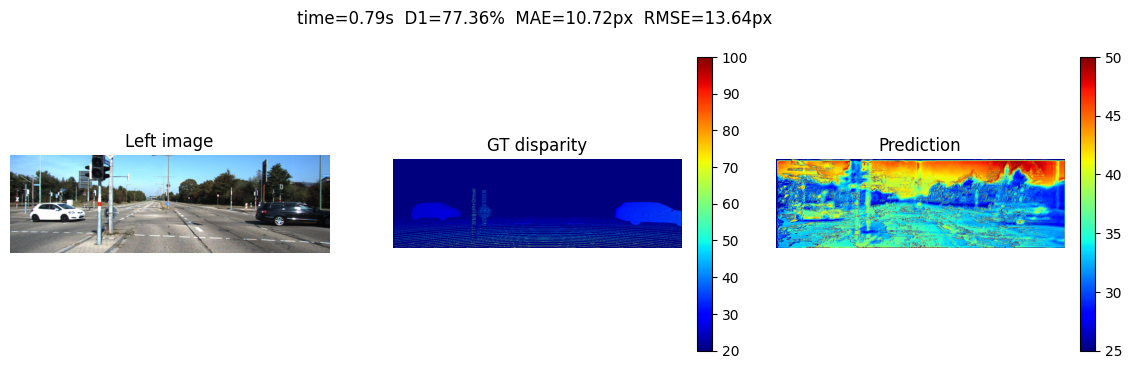

In [ ]:
#vmin, vmax = 20, 50  # consistent for both GT and Prediction

os.makedirs(SAVE_DIR, exist_ok=True)
batch_counter = 0

for (Ls, Rs), Ds in val_ds.take(N_SHOW):
    preds = model([Ls, Rs], training=False)[..., 0].numpy()
    for img_idx in range(Ls.shape[0]):
        single_ds = tf.data.Dataset.from_tensor_slices(
            ((Ls[img_idx][None], Rs[img_idx][None]), Ds[img_idx][None])
        ).batch(1)
        t_img, d1_img, mae_img, rmse_img = evaluate(model, single_ds)

        fig, ax = plt.subplots(1, 3, figsize=(14, 4))

        ax[0].imshow(Ls[img_idx])
        ax[0].set_title("Left image")
        ax[0].axis("off")

        im2 = ax[1].imshow(Ds[img_idx, ..., 0], cmap='jet', vmin=20, vmax=100)
        ax[1].set_title("GT disparity")
        ax[1].axis("off")
        fig.colorbar(im2, ax=ax[1], fraction=0.046)

        im3 = ax[2].imshow(preds[img_idx], cmap='jet', vmin=25, vmax=50)
        ax[2].set_title("Prediction")
        ax[2].axis("off")
        fig.colorbar(im3, ax=ax[2], fraction=0.046)

        fig.suptitle(f"time={t_img:.2f}s  D1={d1_img:.2f}%  MAE={mae_img:.2f}px  RMSE={rmse_img:.2f}px")
        fig.savefig(f"{SAVE_DIR}/sample_{batch_counter}_{img_idx}.png", dpi=150, bbox_inches="tight")
        plt.show()
        plt.close(fig)

    batch_counter += 1


In [ ]:
#vmin, vmax = 20, 50  # consistent for both GT and Prediction

os.makedirs(SAVE_DIR, exist_ok=True)
batch_counter = 0

for (Ls, Rs), Ds in val_ds.take(N_SHOW):
    preds = model([Ls, Rs], training=False)[..., 0].numpy()
    for img_idx in range(Ls.shape[0]):
        single_ds = tf.data.Dataset.from_tensor_slices(
            ((Ls[img_idx][None], Rs[img_idx][None]), Ds[img_idx][None])
        ).batch(1)
        t_img, d1_img, mae_img, rmse_img = evaluate(model, single_ds)

        fig, ax = plt.subplots(1, 3, figsize=(14, 4))

        ax[0].imshow(Ls[img_idx])
        ax[0].set_title("Left image")
        ax[0].axis("off")

        im2 = ax[1].imshow(Ds[img_idx, ..., 0], cmap='jet', vmin=20, vmax=100)
        ax[1].set_title("GT disparity")
        ax[1].axis("off")
        fig.colorbar(im2, ax=ax[1], fraction=0.046)

        im3 = ax[2].imshow(preds[img_idx], cmap='jet', vmin=25, vmax=50)
        ax[2].set_title("Prediction")
        ax[2].axis("off")
        fig.colorbar(im3, ax=ax[2], fraction=0.046)

        fig.suptitle(f"time={t_img:.2f}s  D1={d1_img:.2f}%  MAE={mae_img:.2f}px  RMSE={rmse_img:.2f}px")
        fig.savefig(f"{SAVE_DIR}/sample_{batch_counter}_{img_idx}.png", dpi=150, bbox_inches="tight")
        plt.show()
        plt.close(fig)

    batch_counter += 1


In [ ]:
#vmin, vmax = 20, 50  # consistent for both GT and Prediction

os.makedirs(SAVE_DIR, exist_ok=True)
batch_counter = 0

for (Ls, Rs), Ds in val_ds.take(N_SHOW):
    preds = model([Ls, Rs], training=False)[..., 0].numpy()
    for img_idx in range(Ls.shape[0]):
        single_ds = tf.data.Dataset.from_tensor_slices(
            ((Ls[img_idx][None], Rs[img_idx][None]), Ds[img_idx][None])
        ).batch(1)
        t_img, d1_img, mae_img, rmse_img = evaluate(model, single_ds)

        fig, ax = plt.subplots(1, 3, figsize=(14, 4))

        ax[0].imshow(Ls[img_idx])
        ax[0].set_title("Left image")
        ax[0].axis("off")

        im2 = ax[1].imshow(Ds[img_idx, ..., 0], cmap='turbo', vmin=20, vmax=100)
        ax[1].set_title("GT disparity")
        ax[1].axis("off")
        fig.colorbar(im2, ax=ax[1], fraction=0.046)

        im3 = ax[2].imshow(preds[img_idx], cmap='turbo', vmin=25, vmax=50)
        ax[2].set_title("Prediction")
        ax[2].axis("off")
        fig.colorbar(im3, ax=ax[2], fraction=0.046)

        fig.suptitle(f"time={t_img:.2f}s  D1={d1_img:.2f}%  MAE={mae_img:.2f}px  RMSE={rmse_img:.2f}px")
        fig.savefig(f"{SAVE_DIR}/sample_{batch_counter}_{img_idx}.png", dpi=150, bbox_inches="tight")
        plt.show()
        plt.close(fig)

    batch_counter += 1


Fine-tune and Visualization

Epoch 1/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - loss: 7.0408 - val_loss: 7.1935
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - loss: 6.8954 - val_loss: 7.1573
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 79s 980ms/step - loss: 6.8551 - val_loss: 7.1310
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 78s 980ms/step - loss: 6.8217 - val_loss: 7.1020
Epoch 5/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - loss: 6.7924 - val_loss: 7.0744
Epoch 6/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - loss: 6.7663 - val_loss: 7.0504
Epoch 7/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - loss: 6.7392 - val_loss: 7.0264
Epoch 8/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - loss: 6.7144 - val_loss: 7.0045
Epoch 9/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 80s 981ms/step - loss: 6.6890 - val_loss: 6.9847
Epoch 10/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - loss: 6.6656 - val_loss: 6.9686


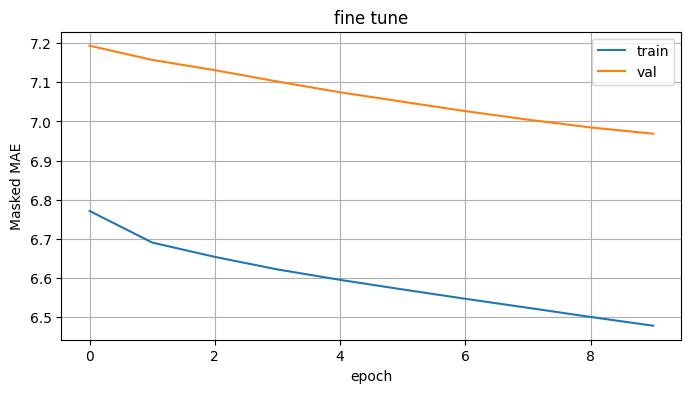

In [ ]:

# ----- fine-tune -----
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss=masked_mae)
hist_ft = model.fit(train_ds, validation_data=val_ds, epochs=10)
plot_loss(hist_ft, "fine tune")


In [ ]:

# ----- final evaluation -----
sec, d1, mae, rmse = evaluate(model, val_ds)
print(f"Disparity computation time: {sec:.2f}s")
print(f"KITTI D1-all error       = {d1:.2f}%")
print(f"MAE: {mae:.2f} px | RMSE: {rmse:.2f} px")


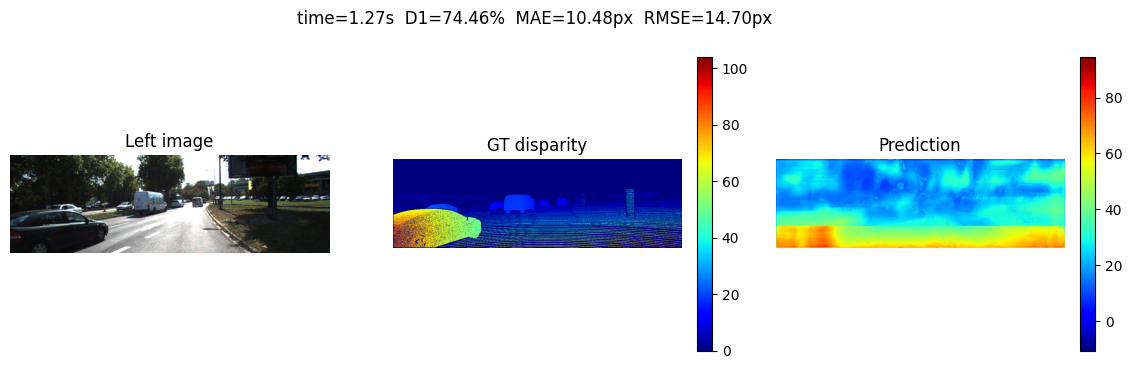

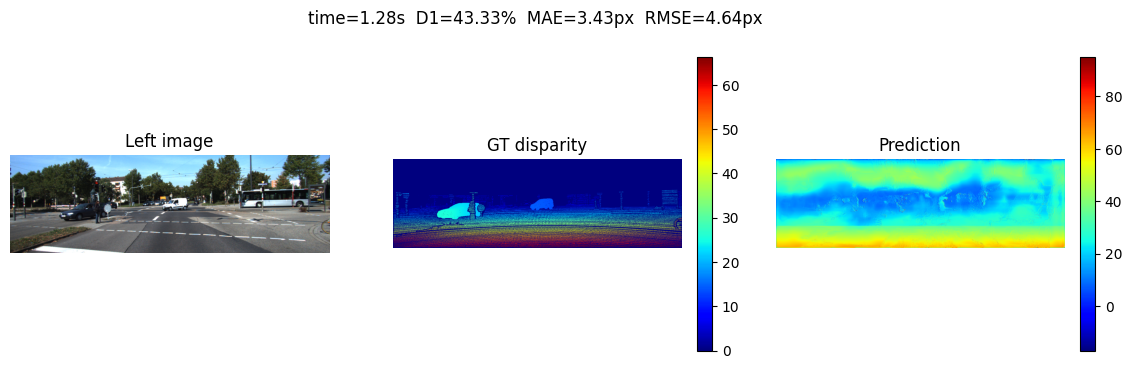

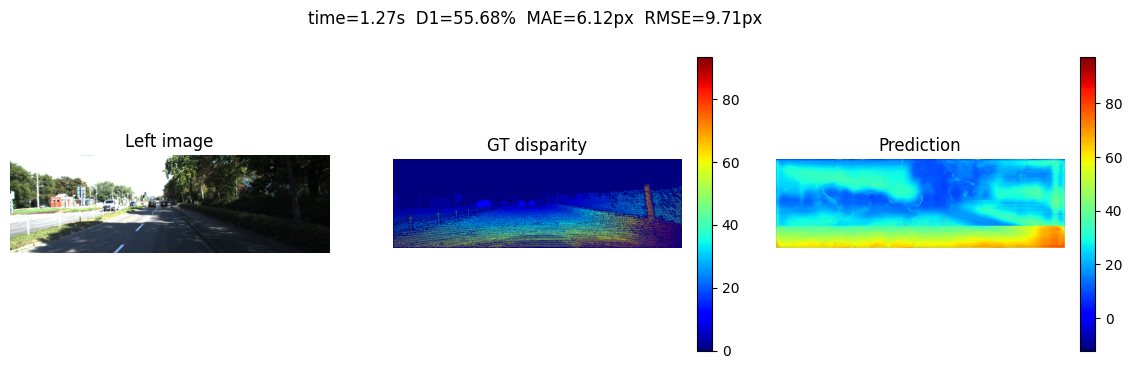

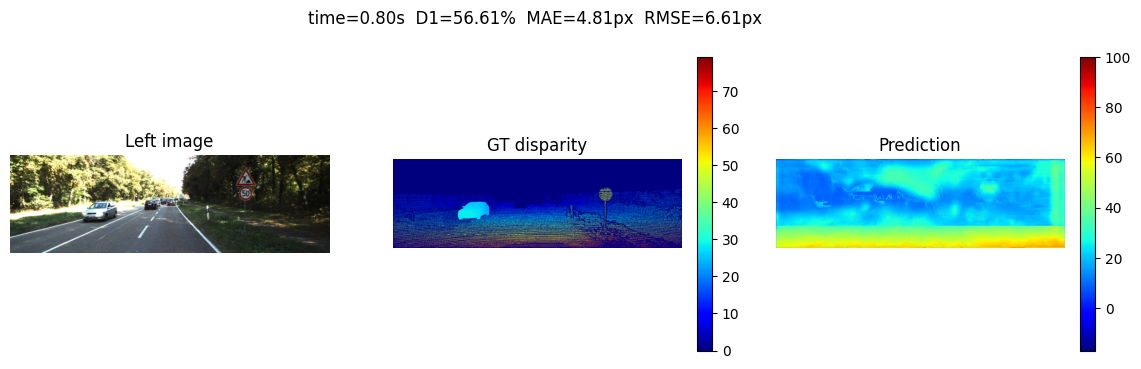

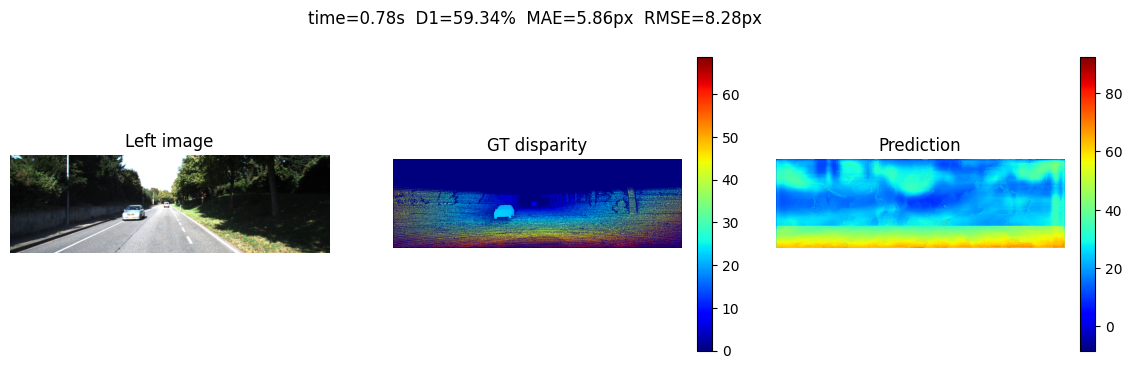

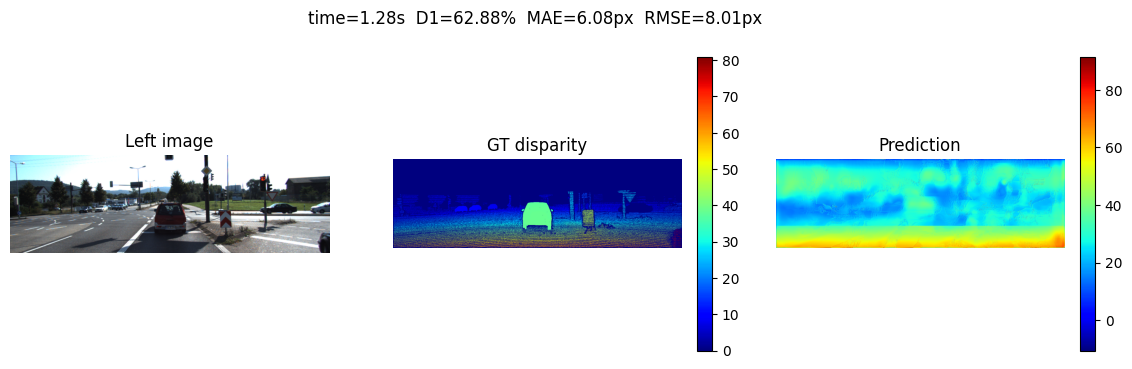

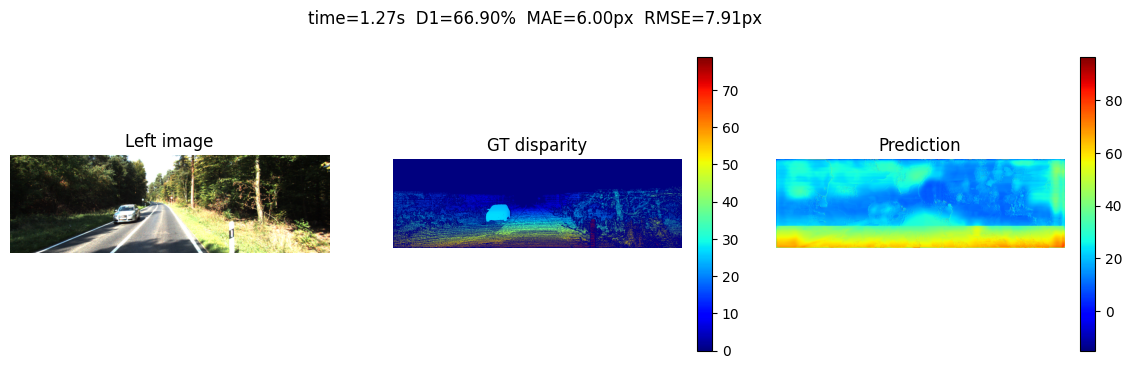

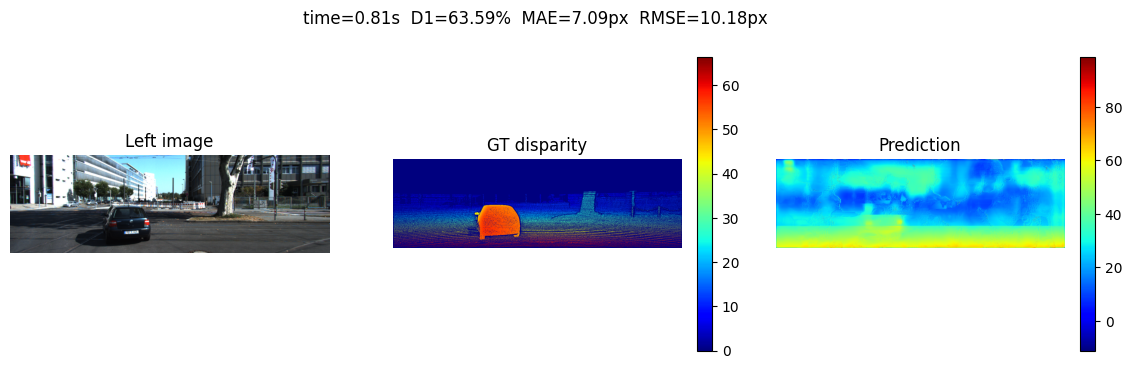

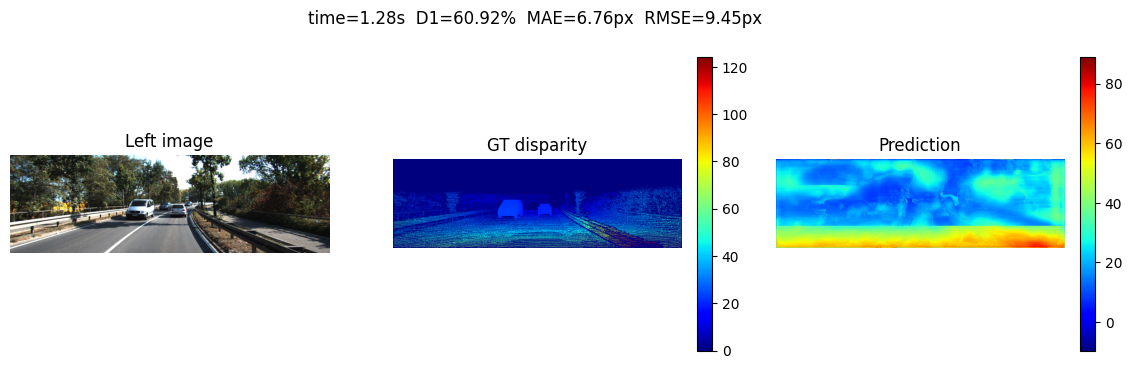

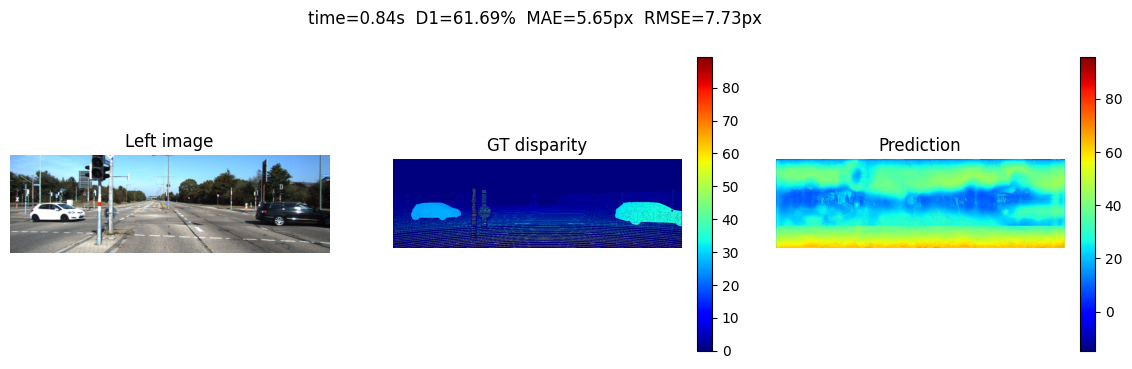

In [ ]:

# ===============================================================
# 6.  Visualise & save validation samples with per-image metrics
# ===============================================================
os.makedirs(SAVE_DIR, exist_ok=True)
batch_counter = 0
for (Ls, Rs), Ds in val_ds.take(N_SHOW):
    preds = model([Ls, Rs], training=False)[..., 0].numpy()
    for img_idx in range(Ls.shape[0]):
        single_ds = tf.data.Dataset.from_tensor_slices(
            ((Ls[img_idx][None], Rs[img_idx][None]), Ds[img_idx][None])
        ).batch(1)
        t_img, d1_img, mae_img, rmse_img = evaluate(model, single_ds)

        fig, ax = plt.subplots(1,3, figsize=(14,4))
        ax[0].imshow(Ls[img_idx]); ax[0].set_title("Left image"); ax[0].axis("off")
        im2 = ax[1].imshow(Ds[img_idx,...,0], cmap='jet')
        ax[1].set_title("GT disparity"); ax[1].axis("off"); fig.colorbar(im2, ax=ax[1], fraction=0.046)
        im3 = ax[2].imshow(preds[img_idx], cmap='jet')
        ax[2].set_title("Prediction"); ax[2].axis("off"); fig.colorbar(im3, ax=ax[2], fraction=0.046)

        fig.suptitle(f"time={t_img:.2f}s  D1={d1_img:.2f}%  MAE={mae_img:.2f}px  RMSE={rmse_img:.2f}px")
        fig.savefig(f"{SAVE_DIR}/sample_{batch_counter}_{img_idx}.png", dpi=150, bbox_inches="tight")
        plt.show(); plt.close(fig)
    batch_counter += 1


In [ ]:

# ----- final evaluation -----
sec, d1, mae, rmse = evaluate(model, val_ds)
print(f"Disparity computation time: {sec:.2f}s")
print(f"KITTI D1-all error       = {d1:.2f}%")
print(f"MAE: {mae:.2f} px | RMSE: {rmse:.2f} px")

Disparity computation time: 1.02s
KITTI D1-all error       = 60.92%
MAE: 7.05 px | RMSE: 10.91 px
